In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.model import WrapHookedTransformer

from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
from tqdm import tqdm
import numpy as np


from src.result_analyzer import ResultAnalyzer

%load_ext autoreload
%autoreload 2

In [2]:
model = WrapHookedTransformer.from_pretrained("gpt2", device="cuda")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [ ]:
import json
data = json.load(open("../data/counterfact.json"))
my_data = []
for i,d in tqdm(enumerate(data), total=len(data)):
    target_true = " " + d["requested_rewrite"]["target_true"]["str"]
    target_new = " " + d["requested_rewrite"]["target_new"]["str"]
    if i % 100 == 0:
        print(len(my_data))
        if len(my_data) > 1000:
            break
    for p in d["neighborhood_prompts"]:
        template = "Redefine: " + p + "{}" + ". " + p
        #find position of {} in template
        if len(model.to_str_tokens(template.format(model.tokenizer.pad_token))) != 19:
            continue
        try:
            obj_pos = model.to_str_tokens(template.format(model.tokenizer.pad_token)).index(".") - 1
        except:
            continue
        position = template.find("{}")
        prediction = model.predict(template.format(model.tokenizer.pad_token))[1][0]
        copy_prediction = model.predict(template.format(target_new))[1][0]
        if prediction == target_true and copy_prediction == target_new:
            my_data.append({
                "prompt": p,
                "template": template,
                "prediction": prediction,
                "copy_prediction": copy_prediction,
                "target_true": target_true,
                "target_new": target_new,
                "length": len(model.to_str_tokens(template.format(model.tokenizer.pad_token))),
                "lenght_copy": len(model.to_str_tokens(template.format(target_new))),
                "obj_pos": obj_pos,
               
            })
        

# json.dump(my_data, open("../data/counterfact_small.json", "w"), indent=2)    

In [3]:
import json
my_data = json.load(open("../data/counterfact_small_15.json"))
# sample random 50 examples
import random
random.seed(124)
random.shuffle(my_data)
my_data = my_data[:700]
print(len(my_data))

700


In [31]:
# json.dump(my_data, open("../data/counterfact_small_15.json", "w"), indent=2)

## Patch

In [22]:
from torch.utils.data import DataLoader, Dataset

class CounterfactDataset(Dataset):
    def __init__(self, data):
        pad_token = model.tokenizer.pad_token
        self.clean_prompts = [d["template"].format(pad_token) for d in data]
        self.corrupted_prompts = [d["template"].format(d["target_new"]) for d in data]

        target1 = [model.to_tokens(d["target_true"], prepend_bos=False) for d in data]
        target2 = [model.to_tokens(d["target_new"], prepend_bos=False) for d in data]
        tensor_1 = torch.stack(target1, dim=0)
        tensor_2 = torch.stack(target2, dim=0)
        # stack the tensors
        self.target = torch.stack([tensor_1, tensor_2], dim=1).squeeze()
    def __len__(self):
        return len(self.clean_prompts)
    def __getitem__(self, idx):
        return {
            "clean_prompts": self.clean_prompts[idx],
            "corrupted_prompts": self.corrupted_prompts[idx],
            "target": self.target[idx]
        }
    def filter_from_idx(self, index, exclude=False):
        if exclude:
            self.target = [self.target[i] for i in range(len(self.target)) if i not in index]
            self.clean_prompts = [self.clean_prompts[i] for i in range(len(self.clean_prompts)) if i not in index]
        
            self.corrupted_prompts = [self.corrupted_prompts[i] for i in range(len(self.corrupted_prompts)) if i not in index]
        else:
            self.target = [self.target[i] for i in index][:200]
            self.clean_prompts = [self.clean_prompts[i] for i in index][:200]
            self.corrupted_prompts = [self.corrupted_prompts[i] for i in index][:200]
    
    def slice(self, end, start=0):
        self.target = self.target[start:end]
        self.clean_prompts = self.clean_prompts[start:end]
        self.corrupted_prompts = self.corrupted_prompts[start:end]
    
        
        
dataset = CounterfactDataset(my_data)
batch_size=50
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_batches = len(dataloader)
torch.set_grad_enabled(False)

clean_logits = []
corrupted_logits = []
target = []
for batch in tqdm(dataloader, total=num_batches):
    clean_logits.append(model(batch["clean_prompts"])[:,-1,:].cpu())
    corrupted_logits.append(model(batch["corrupted_prompts"])[:,-1,:].cpu())
    target.append(batch["target"].cpu())
clean_logit = torch.cat(clean_logits, dim=0)
corrupted_logit = torch.cat(corrupted_logits, dim=0)
target = torch.cat(target, dim=0)

100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


In [23]:
def to_logit_token(logit, target):
    logit = torch.log_softmax(logit, dim=-1)
    logit_mem = torch.zeros(target.shape[0])
    logit_cp = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_mem[i] = logit[i, target[i,0]] 
        logit_cp[i] = logit[i, target[i,1]]
    return logit_mem, logit_cp

CLEAN_LOGIT_MEM = to_logit_token(clean_logit, target)[0]
CLEAN_LOGIT_CP = to_logit_token(clean_logit, target)[1]
CORRUPTED_LOGIT_MEM = to_logit_token(corrupted_logit, target)[0]
CORRUPTED_LOGIT_CP = to_logit_token(corrupted_logit, target)[1]

def normalize_logit_token(logit, target):
    logit_mem, logit_cp = to_logit_token(logit, target)
    # percentage increase or decrease of logit_mem
    logit_mem = 100 * (logit_mem - CLEAN_LOGIT_MEM) / CLEAN_LOGIT_MEM
    # percentage increase or decrease of logit_cp
    logit_cp = 100 * (logit_cp - CLEAN_LOGIT_CP) / CLEAN_LOGIT_CP
    return logit_mem, logit_cp

# get the index of the outliers
outliers_under = torch.where(CORRUPTED_LOGIT_MEM < (CORRUPTED_LOGIT_MEM.mean() - CORRUPTED_LOGIT_MEM.std()) )[0]
outliers_over = torch.where(CORRUPTED_LOGIT_MEM > (CORRUPTED_LOGIT_MEM.mean() + CORRUPTED_LOGIT_MEM.std()) )[0]
outliers_indexes = torch.cat([outliers_under, outliers_over], dim=0).tolist() 
both_high = torch.where((CORRUPTED_LOGIT_MEM > (CORRUPTED_LOGIT_MEM.mean() + CORRUPTED_LOGIT_MEM.std())) & (CLEAN_LOGIT_CP > (CLEAN_LOGIT_CP.mean() + CLEAN_LOGIT_CP.std())))[0]

print("Both high: ", len(both_high), len(list(set(both_high.tolist()).intersection(set(outliers_indexes)))))
print("Outliers found: ", 100 * len(outliers_indexes)/len(my_data), "%")

maxdatasize = ((len(my_data) - len(outliers_indexes)) // batch_size) * batch_size

dataset.filter_from_idx(outliers_indexes, exclude=True)
dataset.slice(maxdatasize)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_batches = len(dataloader)
torch.set_grad_enabled(False)
print("dataset len:",len(dataset))

clean_logits = []
corrupted_logits = []
target = []
for batch in tqdm(dataloader, total=num_batches):
    clean_logits.append(model(batch["clean_prompts"])[:,-1,:].cpu())
    corrupted_logits.append(model(batch["corrupted_prompts"])[:,-1,:].cpu())
    target.append(batch["target"].cpu())
clean_logit = torch.cat(clean_logits, dim=0)
corrupted_logit = torch.cat(corrupted_logits, dim=0)
target = torch.cat(target, dim=0)

Both high:  23 23
Outliers found:  26.428571428571427 %
dataset len: 500


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


In [44]:
def to_logit_token(logit, target):
    logit = torch.log_softmax(logit, dim=-1)
    logit_mem = torch.zeros(target.shape[0])
    logit_cp = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_mem[i] = logit[i, target[i,0]] 
        logit_cp[i] = logit[i, target[i,1]]
    return logit_mem, logit_cp

CLEAN_LOGIT_MEM = to_logit_token(clean_logit, target)[0]
CLEAN_LOGIT_CP = to_logit_token(clean_logit, target)[1]
CORRUPTED_LOGIT_MEM = to_logit_token(corrupted_logit, target)[0]
CORRUPTED_LOGIT_CP = to_logit_token(corrupted_logit, target)[1]

def normalize_logit_token(logit_mem, logit_cp, baseline="corrupted"):
    # logit_mem, logit_cp = to_logit_token(logit, target)
    # percentage increase or decrease of logit_mem
    if baseline == "clean":
        logit_mem = 100 * (logit_mem - CLEAN_LOGIT_MEM) / CLEAN_LOGIT_MEM
        # percentage increase or decrease of logit_cp
        logit_cp = 100 * (logit_cp - CLEAN_LOGIT_CP) / CLEAN_LOGIT_CP
        return -logit_mem, -logit_cp
    elif baseline == "corrupted":
        logit_mem = 100 * (logit_mem - CORRUPTED_LOGIT_MEM) / CORRUPTED_LOGIT_MEM
        # percentage increase or decrease of logit_cp
        logit_cp = 100 * (logit_cp - CORRUPTED_LOGIT_CP) / CORRUPTED_LOGIT_CP
        return -logit_mem, -logit_cp

In [62]:
normalize_logit_token(CORRUPTED_LOGIT_MEM, CORRUPTED_LOGIT_CP, "corrupted")[0].mean()

tensor(89.9569)

In [6]:
def to_logit_diff(logit, target):
    logit = torch.log_softmax(logit, dim=-1)
    # logit has shape (batch_size, vocab_size), target has shape (batch_size, 2)
    # we want to compute the difference between the two tokens in target for each batch
    # so we need to index logit with target
    logit_diff = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_diff[i] = logit[i, target[i,0]] - logit[i, target[i,1]]
    # print(logit_of_target.shape)
    # print(logit_of_target[:10])
    # # for each batch, we want to compute the difference between the two tokens in target
    # logit_diff = logit_of_target[:, 0] - logit_of_target[:, 1]
    return logit_diff

CLEAN_LOGIT_DIFF = to_logit_diff(clean_logit, target)
CORRUPTED_LOGIT_DIFF = to_logit_diff(corrupted_logit, target)

def normalize_logit_diff(logit_diff):
    # variation in logit diff is between -1 and 1
    # return 100 * (logit_diff - CLEAN_LOGIT_DIFF) / CLEAN_LOGIT_DIFF
    return (logit_diff - CLEAN_LOGIT_DIFF) / (CORRUPTED_LOGIT_DIFF - CLEAN_LOGIT_DIFF)

def normalize_logit_diff(new_logit_diff, baseline:str="clean"):
    if baseline == "clean":

        # Calculate the percentage change relative to the clean_logit_diff
        perc_change = 100 * (new_logit_diff - CLEAN_LOGIT_DIFF) / (CLEAN_LOGIT_DIFF + 1e-9)
        
        
        return perc_change
    if baseline == "corrupted":
        
        # Calculate the percentage change relative to the clean_logit_diff
        perc_change = 100 * (-new_logit_diff - (-CORRUPTED_LOGIT_DIFF)) / ((-CORRUPTED_LOGIT_DIFF) + 1e-9)
        
        return perc_change
    
    




100%|██████████| 12/12 [06:27<00:00, 32.31s/it]


<Axes: title={'center': 'Std logit difference'}>

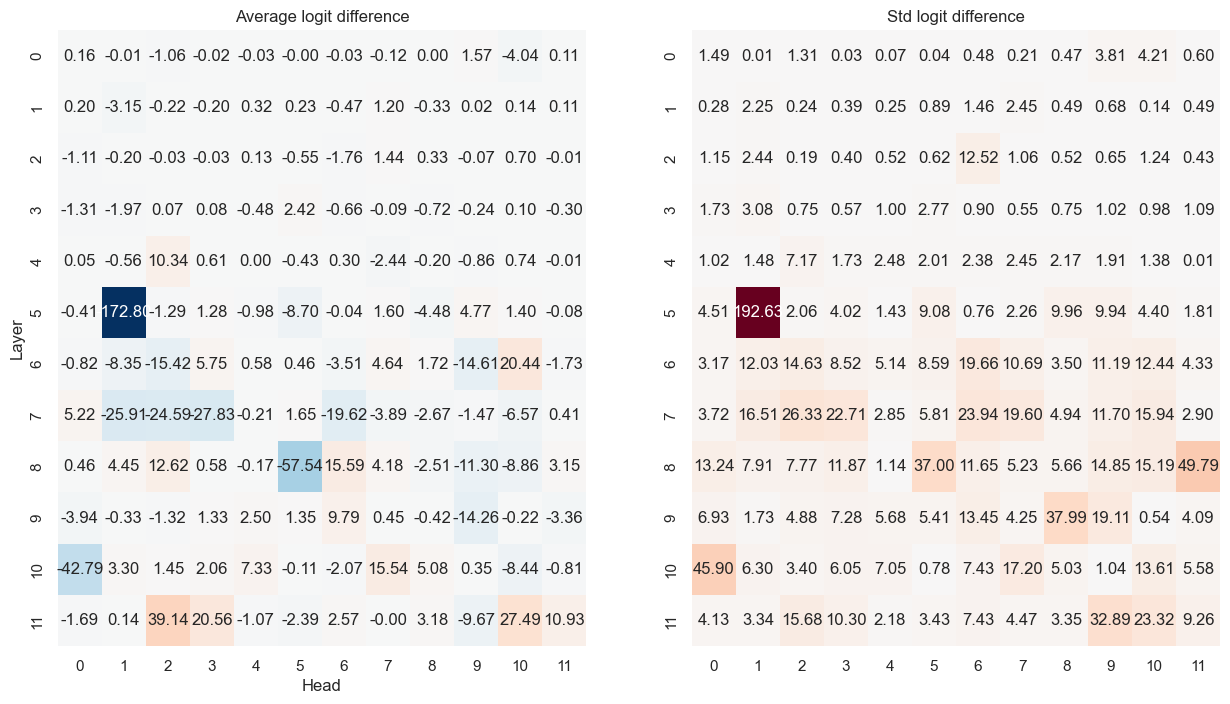

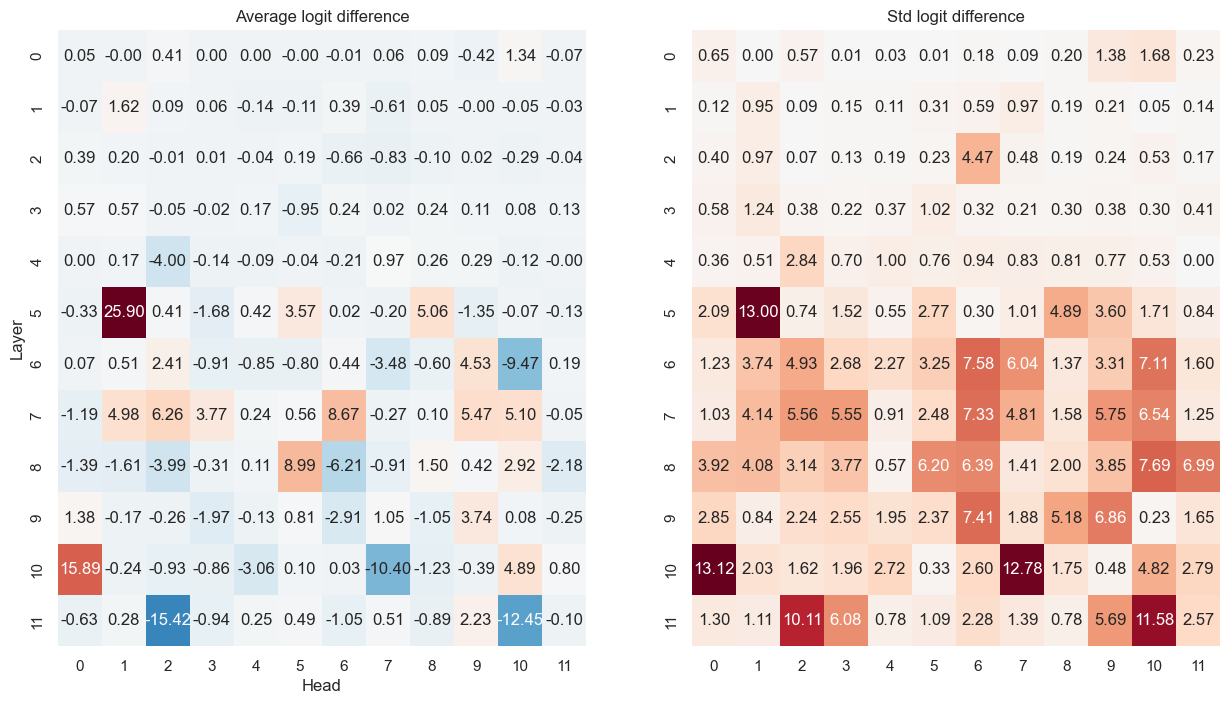

In [63]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result_mem = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_cp = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_mem_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_cp_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_mem = torch.zeros(num_batches, batch_size)
        logit_cp = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["clean_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["corrupted_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            mem, cp = to_logit_token(logit, batch["target"])
            logit_mem[idx,:] = mem
            logit_cp[idx,:] = cp
        
        logit_mem = logit_mem.flatten()
        logit_cp = logit_cp.flatten()
        norm_mem, norm_cp = normalize_logit_token(logit_mem, logit_cp, "corrupted")
        result_mem[layer, head] = norm_mem.mean()
        result_cp[layer, head] = norm_cp.mean()
        result_mem_std[layer, head] = norm_mem.std()
        result_cp_std[layer, head] = norm_cp.std()

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_cp.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_cp_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_mem.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_mem_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [64]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result_mem = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_cp = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_mem_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_cp_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_mem = torch.zeros(num_batches, batch_size)
        logit_cp = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["clean_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            mem, cp = to_logit_token(logit, batch["target"])
            logit_mem[idx,:] = mem
            logit_cp[idx,:] = cp
        
        logit_mem = logit_mem.flatten()
        logit_cp = logit_cp.flatten()
        norm_mem, norm_cp = normalize_logit_token(logit_mem, logit_cp, "clean")
        result_mem[layer, head] = norm_mem.mean()
        result_cp[layer, head] = norm_cp.mean()
        result_mem_std[layer, head] = norm_mem.std()
        result_cp_std[layer, head] = norm_cp.std()

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_cp.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_cp_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_mem.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_mem_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

  0%|          | 0/12 [00:00<?, ?it/s]

## Patch head

In [ ]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_diff = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["clean_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["corrupted_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            logit_diff[idx,:] = to_logit_diff(logit, batch["target"])
        
        
        logit_diff = logit_diff.flatten()
        avg_logit_diff = normalize_logit_diff(logit_diff, "corrupted").mean(0)
        layer_head_examples[layer, head, :] = normalize_logit_diff(logit_diff, "corrupted")
        result[layer, head] = avg_logit_diff
        result_std[layer, head] = normalize_logit_diff(logit_diff, "corrupted").std(0)

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [31]:
layer, head = 5,1
print((layer_head_examples[layer,head] < 0).sum())
print((layer_head_examples[layer,head] > 0).sum())


tensor(48)
tensor(2)


In [40]:
#get indices for negative and positive examples
negative_examples = torch.where(layer_head_examples[layer,head] < 0)[0]
print(negative_examples)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49])


In [48]:
CORRUPTED_LOGIT_DIFF[22]

tensor(-0.4551)

In [47]:
layer_head_examples[11,2,22]

tensor(167.7800)

In [32]:
layer_head_examples[layer,head].topk(10)

torch.return_types.topk(
values=tensor([175.1378,   8.4963, -34.1543, -35.4600, -37.4804, -46.6242, -47.3845,
        -51.6562, -53.9275, -55.6644]),
indices=tensor([42, 21,  7, 44, 34, 19, 14, 33, 24, 27]))

In [44]:
import circuitsvis as cv
index = 49
clean_prompt, corrupted_prompt = dataset[index]["clean_prompts"], dataset[index]["corrupted_prompts"]
logit, cache = model.run_with_cache(clean_prompt)
cv.attention.attention_patterns(model.to_str_tokens(clean_prompt), cache["pattern",layer][0])

In [45]:
import circuitsvis as cv
index = 49
clean_prompt, corrupted_prompt = dataset[index]["clean_prompts"], dataset[index]["corrupted_prompts"]
logit, cache = model.run_with_cache(corrupted_prompt)
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompt), cache["pattern",layer][0])

In [13]:
len(dataloader)

4

100%|██████████| 12/12 [06:28<00:00, 32.34s/it]


<Axes: title={'center': 'Std logit difference'}>

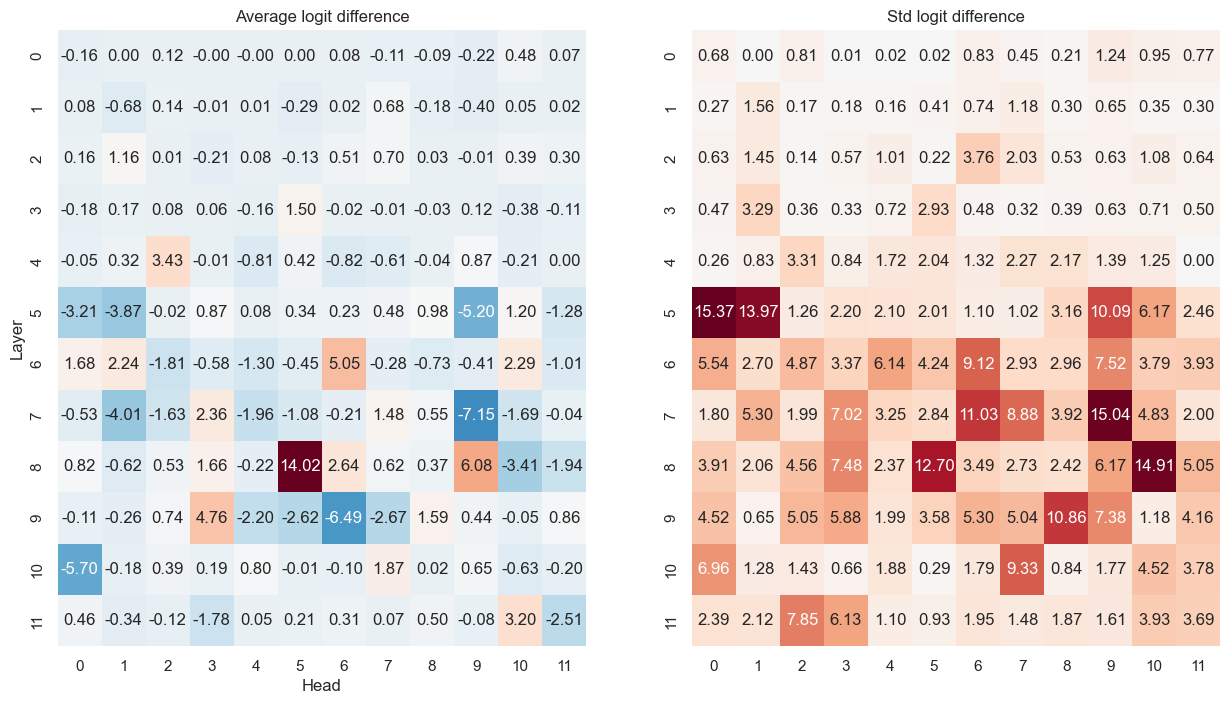

In [7]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_diff = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["clean_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            logit_diff[idx,:] = to_logit_diff(logit, batch["target"])
        
        
        logit_diff = logit_diff.flatten()
        avg_logit_diff = normalize_logit_diff(logit_diff, "clean").mean(0)
        layer_head_examples[layer, head, :] = normalize_logit_diff(logit_diff, "clean")
        result[layer, head] = avg_logit_diff
        result_std[layer, head] = normalize_logit_diff(logit_diff, "clean").std(0)

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [10]:
def get_prob(prompt, model, target):
    probs = torch.softmax(model(prompt), dim=-1)[:,-1,:]
    return probs[:, target]

In [47]:
# CONSTRUCT A DATAFRAME WITH THE PROMPTS OF THE POSITIVE EXAMPLES AND THEIR LOGIT DIFFERENCE
# for layer 5, and head 1 cluster all the examples that have a logit difference > 0.1 and < 0.1 and 0
layer, head = 8, 9
mean = result[layer, head]
quartile = result_std[layer, head]
positive_examples_id = torch.where(layer_head_examples[layer, head, :] > mean + quartile)[0]
negative_examples_id = torch.where(layer_head_examples[layer, head, :] < mean - quartile)[0]


import pandas as pd
positive_examples = []
for idx in positive_examples_id:
    positive_examples.append({
        "prompt": dataset.corrupted_prompts[idx],
        "logit_diff": layer_head_examples[8, 5, idx].item(),
        "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 1]).item()
    })
positive_examples = pd.DataFrame(positive_examples)

negative_examples = []
for idx in negative_examples_id:
    negative_examples.append({
        "prompt": dataset.corrupted_prompts[idx],
        "logit_diff": layer_head_examples[8, 5, idx].item(),
        "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 1]).item()
    })
negative_examples = pd.DataFrame(negative_examples)
positive_examples.head()
#plot distribution of target_probs and copy_probs
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Positive examples")
ax[1].set_title("Negative examples")
sns.histplot(data=positive_examples, x="target_probs", ax=ax[0], kde=True, label="mem")
sns.histplot(data=positive_examples, x="copy_probs", ax=ax[0],kde=True, label="cp")
sns.histplot(data=negative_examples, x="target_probs", ax=ax[1], kde=True, label="mem")
sns.histplot(data=negative_examples, x="copy_probs", ax=ax[1], kde=True, label="cp")
# show labels
ax[0].legend()
ax[1].legend()
fig.suptitle("Corrutped prompts")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   positive_examples.append({                                                              │
│   14 │   │   "prompt": dataset.corrupted_prompts[idx],                                           │
│   15 │   │   "logit_diff": layer_head_examples[8, 5, idx].item(),                                │
│ ❱ 16 │   │   "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[i    │
│   17 │   │   "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx    │
│   18 │   })                                                                                      │
│   19 positive_examples = pd.DataFrame(positive_examples)                                         │
│                                                                                                  │
│ in get_prob:2                                                                                    │
│                                                                                                  │
│   1 def get_prob(prompt, model, target):                                                         │
│ ❱ 2 │   probs = torch.softmax(model(prompt), dim=-1)[:,-1,:]                                     │
│   3 │   return probs[:, target]                                                                  │
│   4                                                                                              │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/transformer_lens/HookedTransfo │
│ rmer.py:451 in forward                                                                           │
│                                                                                                  │
│    448 │   │   │   │   │   tokens,                                                               │
│    449 │   │   │   │   │   shortformer_pos_embed,                                                │
│    450 │   │   │   │   │   left_attention_mask,                                                  │
│ ❱  451 │   │   │   │   ) = self.input_to_embed(                                                  │
│    452 │   │   │   │   │   input,                                                                │
│    453 │   │   │   │   │   prepend_bos=prepend_bos,                                              │
│    454 │   │   │   │   │   padding_side=padding_side,                                            │
│                                                            

In [ ]:
# CONSTRUCT A DATAFRAME WITH THE PROMPTS OF THE POSITIVE EXAMPLES AND THEIR LOGIT DIFFERENCE
import pandas as pd
positive_examples = []
for idx in positive_examples_id:
    positive_examples.append({
        "prompt": dataset.clean_prompts[idx],
        "logit_diff": layer_head_examples[5, 1, idx].item(),
        "target_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 1]).item()
    })
positive_examples = pd.DataFrame(positive_examples)

negative_examples = []
for idx in negative_examples_id:
    negative_examples.append({
        "prompt": dataset.clean_prompts[idx],
        "logit_diff": layer_head_examples[5, 1, idx].item(),
        "target_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 1]).item()
    })
negative_examples = pd.DataFrame(negative_examples)
positive_examples.head()



In [44]:
# Initialize a dictionary to store counts and another to store example indices
count_dict = {}
example_indices_dict = {}

# Loop through layers and heads to find best and worst heads
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_heads):
        key = f"L{i}H{j}"
        count_dict[key] = {'head_id': key, 'count_best_head': 0, 'count_second_best_head': 0, 'count_worst_head': 0, 'count_second_worst_head': 0}
        example_indices_dict[key] = {'best_head_examples': [], 'second_best_head_examples': []}

# Analyze the tensor to populate the counts and example indices
for n in range(50):
    # Flatten the layer and head dimensions
    example_values = layer_head_examples[:, :, n].flatten()
    
    # Sort the flattened tensor
    sorted_indices = torch.argsort(example_values)
    
    # Find global best and second-best heads
    global_best_idx = sorted_indices[-1].item()
    global_second_best_idx = sorted_indices[-2].item()
    
    # Compute the layer and head index for the global best and second-best heads
    best_layer, best_head = divmod(global_best_idx, 12)
    second_best_layer, second_best_head = divmod(global_second_best_idx, 12)
    
    # Create the keys
    best_head_key = f"L{best_layer}H{best_head}"
    second_best_head_key = f"L{second_best_layer}H{second_best_head}"
    
    # Update the counts
    count_dict[best_head_key]['count_best_head'] += 1
    count_dict[second_best_head_key]['count_second_best_head'] += 1
    
    # Update the example indices
    example_indices_dict[best_head_key]['best_head_examples'].append(n)
    example_indices_dict[second_best_head_key]['second_best_head_examples'].append(n)

# Convert the dictionary to DataFrame
df = pd.DataFrame.from_dict(count_dict, orient='index')
df.reset_index(drop=True, inplace=True)
# Now, example_indices_dict contains the indices of examples for best and second best heads


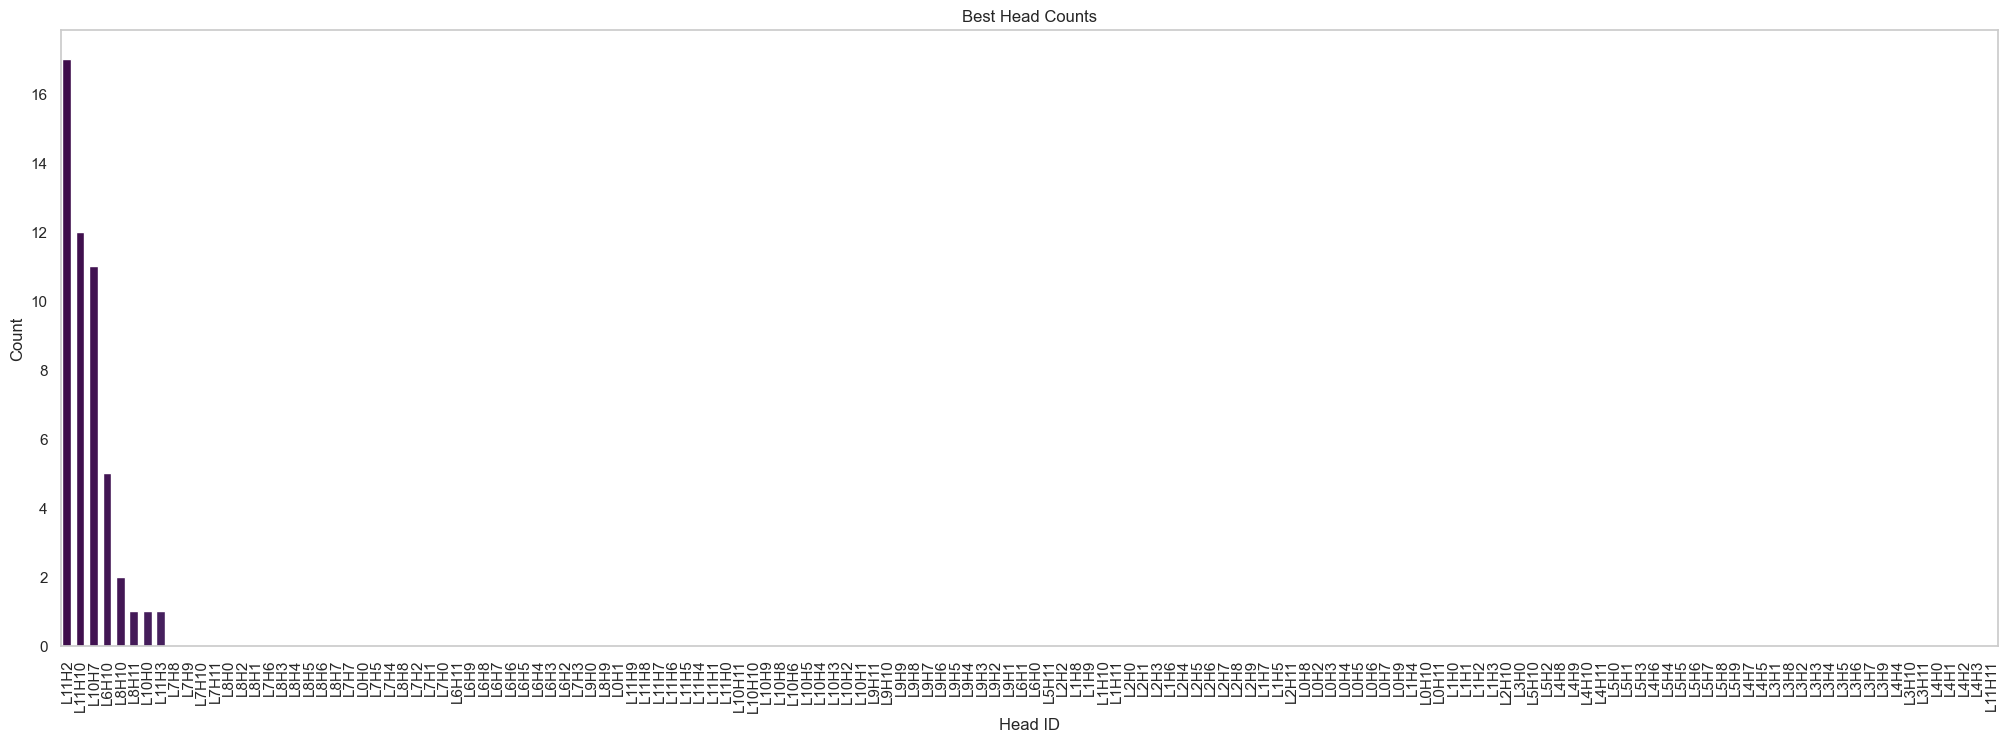

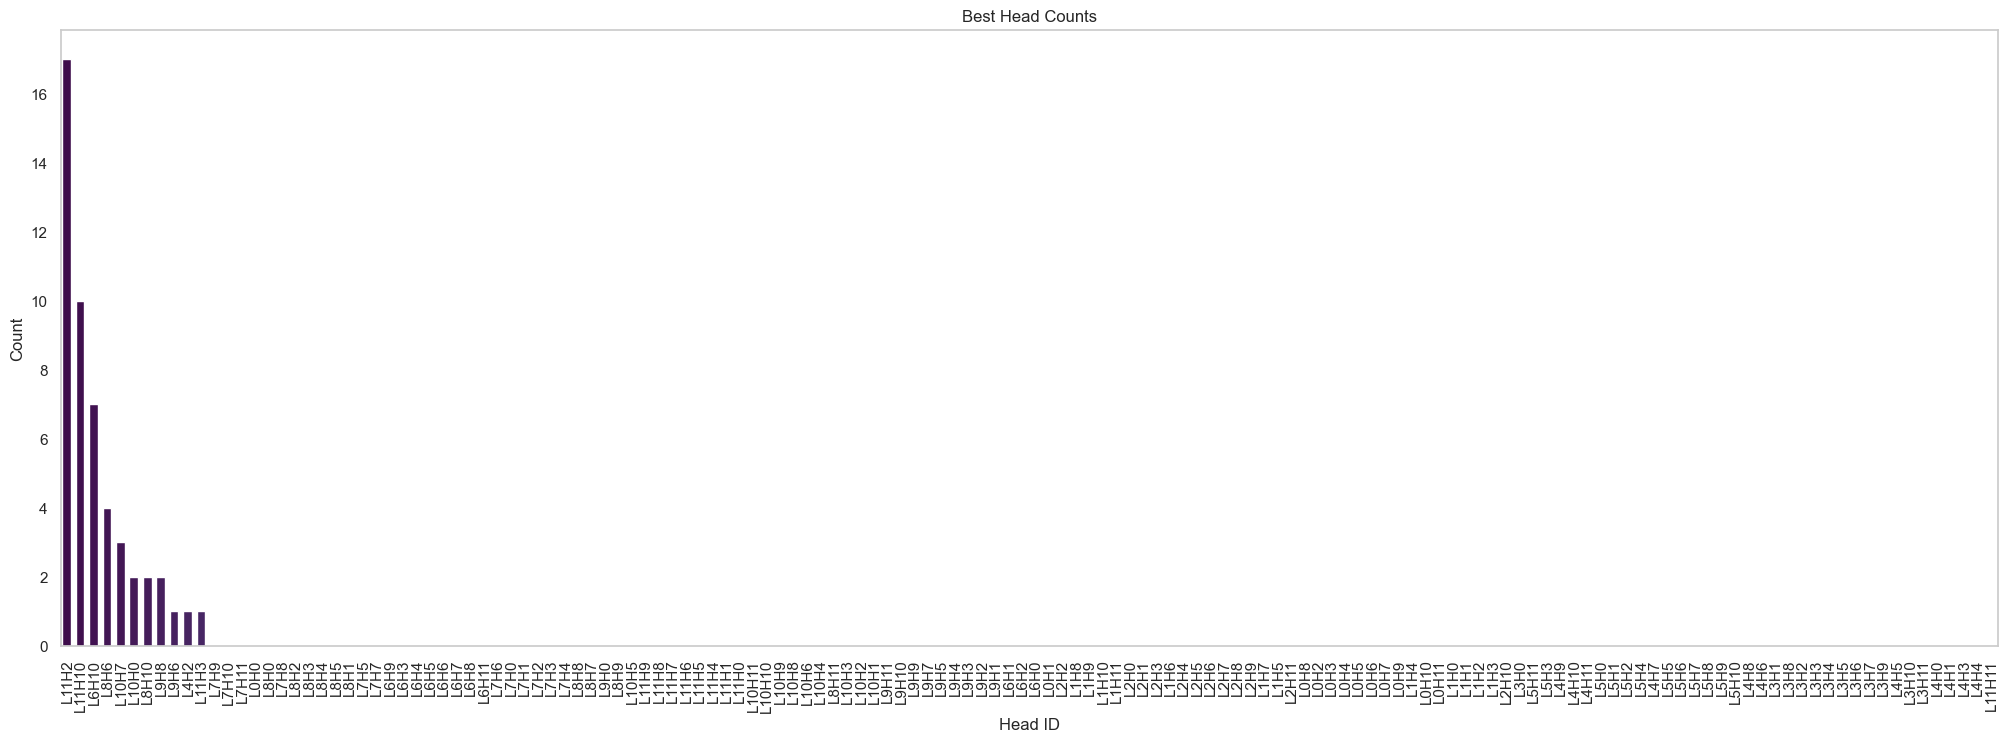

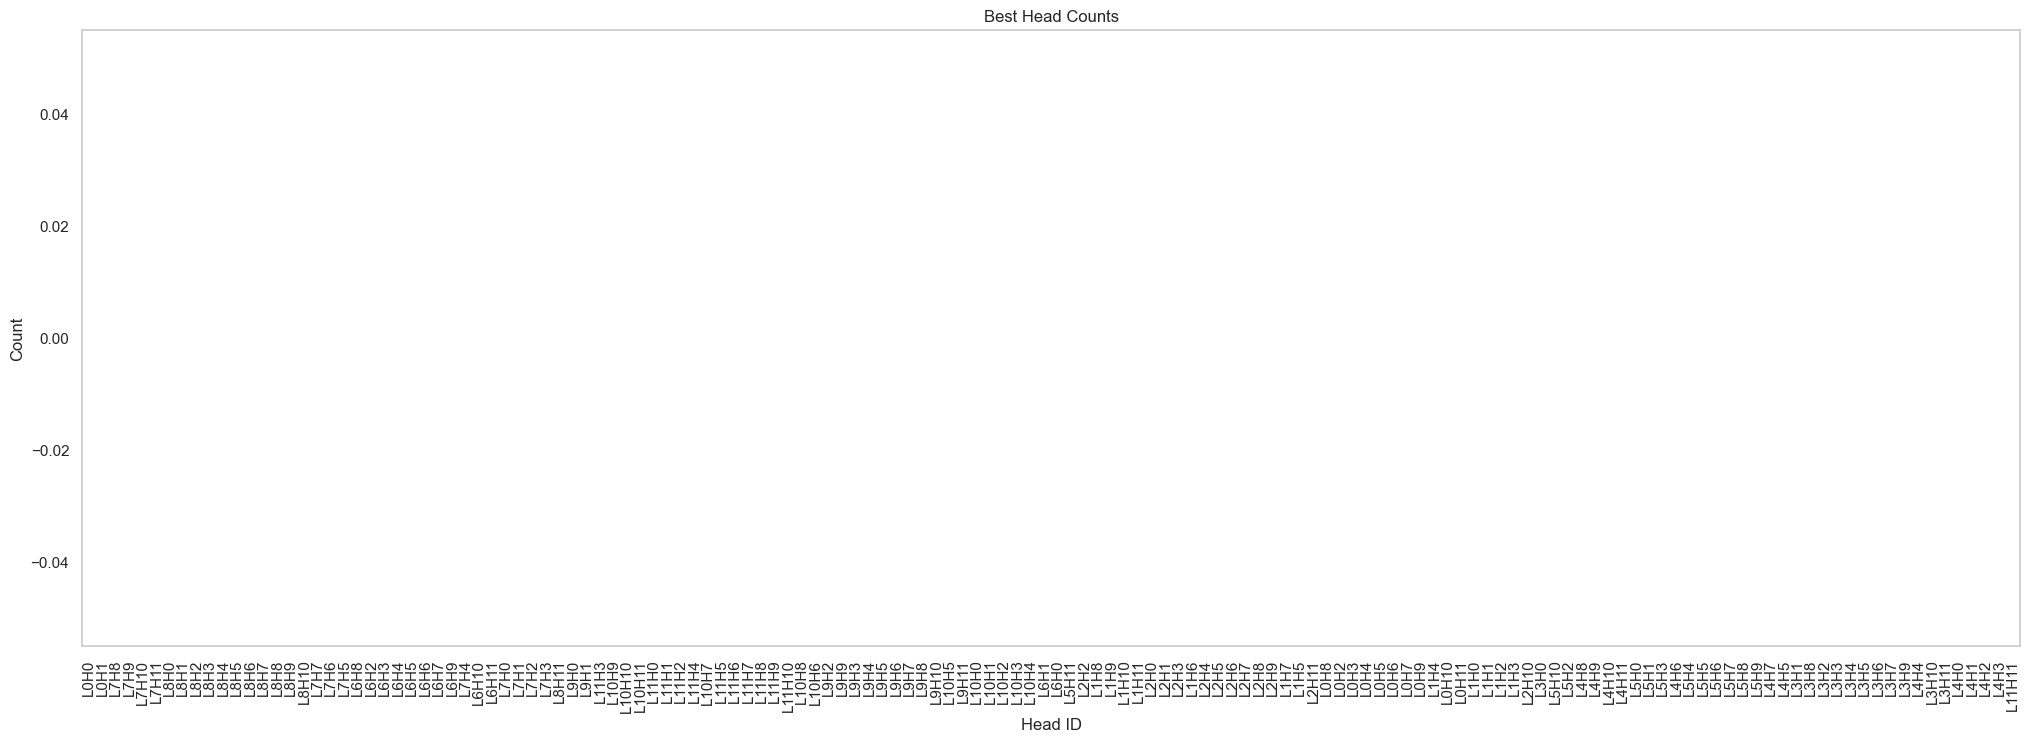

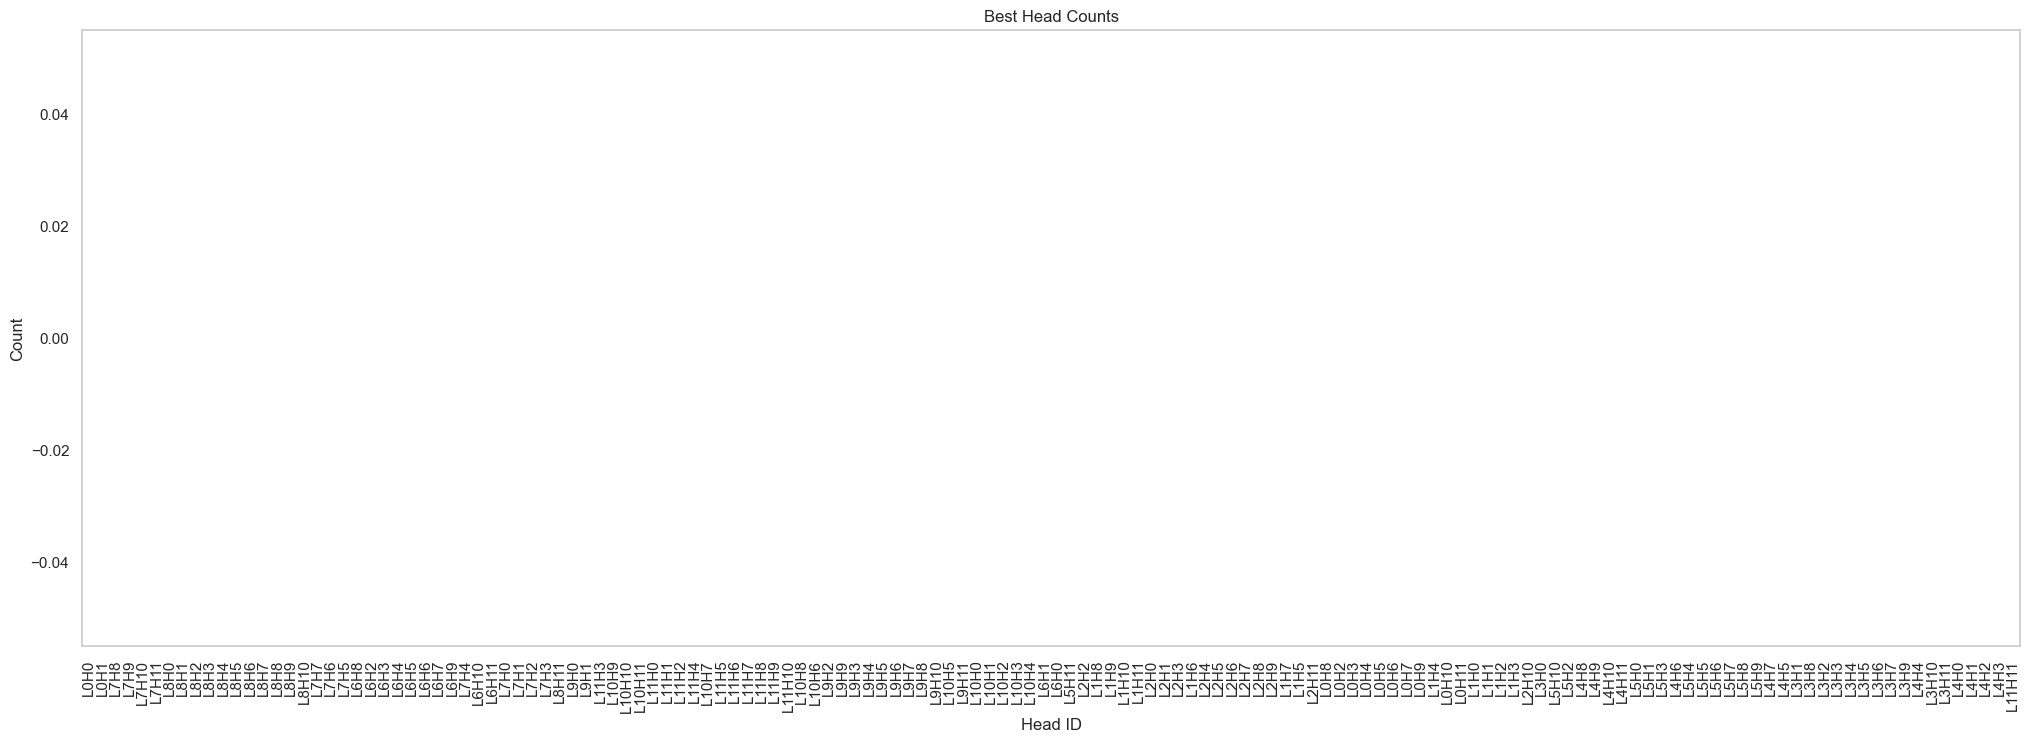

In [46]:
df_best = df[['head_id', 'count_best_head']].sort_values(by='count_best_head', ascending=False)

# Create the barplot with larger bars
plt.figure(figsize=(25, 8))
sns.barplot(x='head_id', y='count_best_head', data=df_best, palette='viridis')

plt.title('Best Head Counts')
plt.xlabel('Head ID')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Optional: rotate x-axis labels for better visibility

# Increase bar width
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    p.set_width(width * 0.8)

plt.show()

df_best_second = df[['head_id', 'count_second_best_head']].sort_values(by='count_second_best_head', ascending=False)

# Create the barplot with larger bars
plt.figure(figsize=(25, 8))
sns.barplot(x='head_id', y='count_second_best_head', data=df_best_second, palette='viridis')

plt.title('Best Head Counts')
plt.xlabel('Head ID')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Optional: rotate x-axis labels for better visibility

# Increase bar width
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    p.set_width(width * 0.8)

plt.show()

df_worst = df[['head_id', 'count_worst_head']].sort_values(by='count_worst_head', ascending=False)

# Create the barplot with larger bars
plt.figure(figsize=(25, 8))
sns.barplot(x='head_id', y='count_worst_head', data=df_worst, palette='viridis')

plt.title('Best Head Counts')
plt.xlabel('Head ID')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Optional: rotate x-axis labels for better visibility

# Increase bar width
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    p.set_width(width * 0.8)

plt.show()

df_second_worst = df[['head_id', 'count_second_worst_head']].sort_values(by='count_second_worst_head', ascending=False)

# Create the barplot with larger bars
plt.figure(figsize=(25, 8))
sns.barplot(x='head_id', y='count_second_worst_head', data=df_second_worst, palette='viridis')

plt.title('Best Head Counts')
plt.xlabel('Head ID')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Optional: rotate x-axis labels for better visibility

# Increase bar width
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    p.set_width(width * 0.8)

plt.show()



In [ ]:
#filter the idx that have 

In [83]:
# patch attention head
from functools import partial
from tqdm import tqdm

def patching(hook:str):
    assert hook in ["mlp", "attn", "resid_pre", "resid_post", "resid_mid"], "hook must be one of mlp, attn, resid_pre, resid_post, resid_mid"
    if hook in ["mlp", "attn"]:
        hook_name = f"hook_{hook}_out"
    else:
        hook_name = f"hook_{hook}"
    def out_hook(activation, hook, pos, clean_activation):
        activation[:, pos, :] = clean_activation[:, pos, :]
        return activation

    result = torch.zeros((model.cfg.n_layers, 19))
    result_std = torch.zeros((model.cfg.n_layers, 19))
    example_per_layer = torch.zeros((model.cfg.n_layers, 19, batch_size*num_batches))
    for layer in tqdm(range(model.cfg.n_layers), total=model.cfg.n_layers):
        for pos in range(19):
            logit_diff = torch.zeros(num_batches, batch_size)
            for idx, batch in enumerate(dataloader):
                corrupted_logit, corrupted_cache = model.run_with_cache(batch["clean_prompts"])
                hook = partial(out_hook, pos=pos, clean_activation=corrupted_cache[f"blocks.{layer}.{hook_name}"])
                logit = model.run_with_hooks(
                    batch["corrupted_prompts"],
                    fwd_hooks=[(f"blocks.{layer}.{hook_name}", hook)],
                )[:,-1,:]

                logit_diff[idx,:] = to_logit_diff(logit, batch["target"])
            
            logit_diff = logit_diff.flatten()
            # result[layer, pos] = logit_diff.mean(dim=0)
            # result_std[layer, pos] = logit_diff.std(dim=0)
            avg_logit_diff = normalize_logit_diff(logit_diff, "corrupted").mean(dim=0)
            example_per_layer[layer, pos, :] = normalize_logit_diff(logit_diff, "corrupted")
            result[layer, pos] = avg_logit_diff
            result_std[layer, pos] = normalize_logit_diff(logit_diff, "corrupted").std(dim=0)

    # plot the result as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()
    sns.set_style("whitegrid", {"axes.grid": False})
    # add also the std heatmap
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    ax[0].set_title("Average logit difference")
    ax[1].set_title("Std logit difference")
    # make the center of the heatmap 0 and white color
    sns.heatmap(
        result.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[0],
        center=0.0,
        cmap="RdBu_r",
    )
    # label the axes
    ax[0].set_xlabel("Head")
    ax[0].set_ylabel("Layer")
    sns.heatmap(
        result_std.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[1],
        center=0.0,
        cmap="RdBu_r",
    )
    return result, result_std, example_per_layer

100%|██████████| 12/12 [01:58<00:00,  9.84s/it]


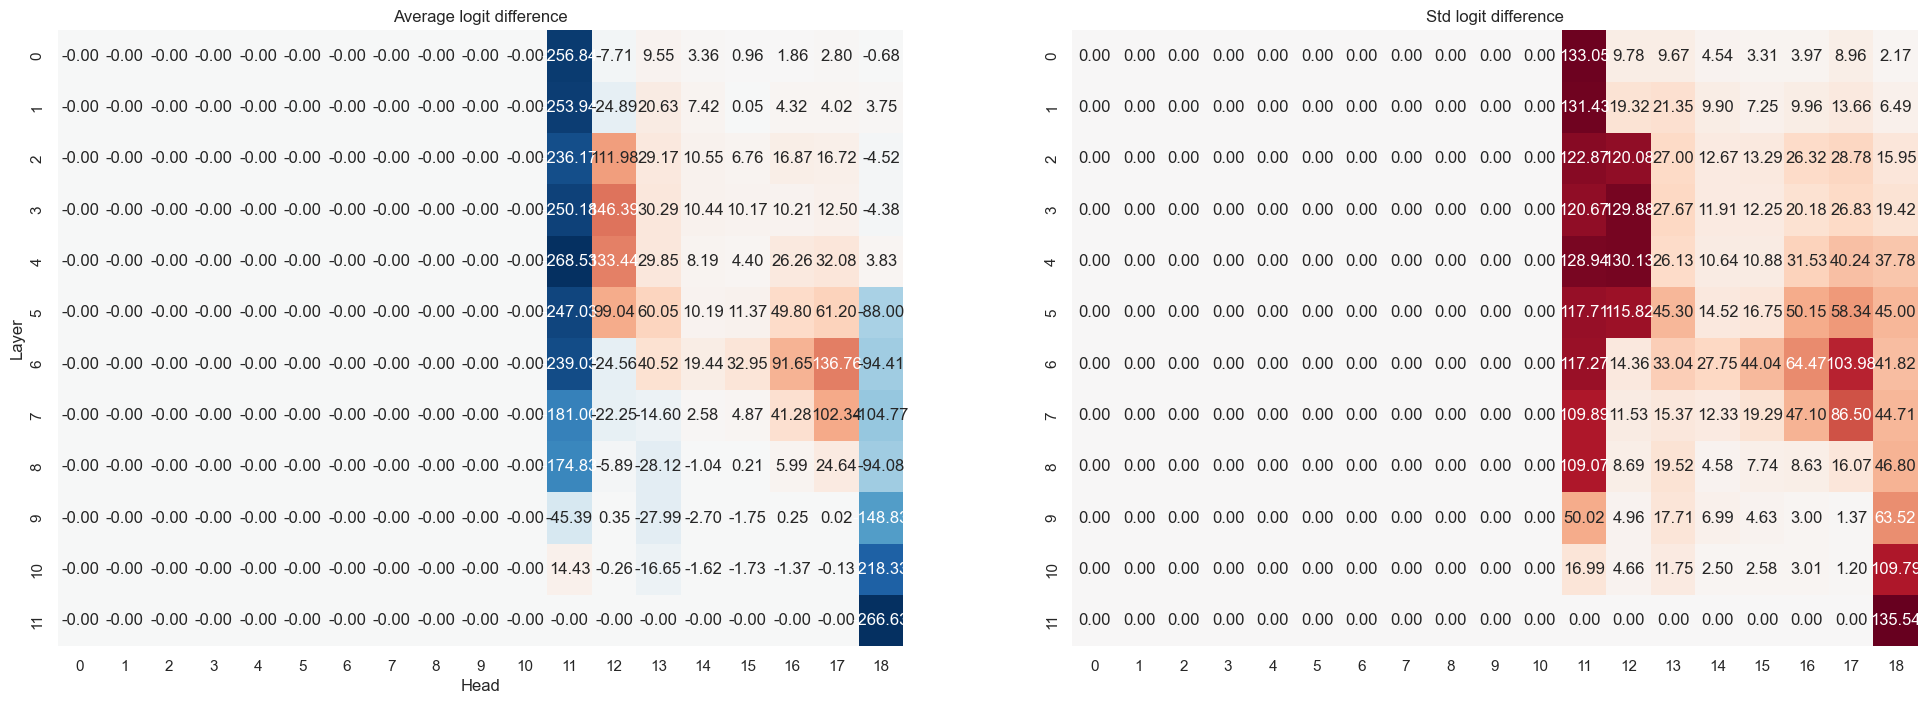

In [45]:
result, result_std, example_per_lyer = patching("resid_post")


In [51]:

example_per_lyer[3,12].std()

tensor(129.8779)

In [29]:
no_outlier.mean()

tensor(123.1037)

In [23]:
#no outliers take example without 28
no_outlier = example_per_lyer[4,12,:]

In [17]:
batch = next(iter(dataloader))
cprompt = batch["corrupted_prompts"][28]
print(cprompt)

Redefine: Adobe Acrobat is created by Microsoft. Adobe Acrobat is created by


<Axes: title={'center': 'Std logit difference'}>

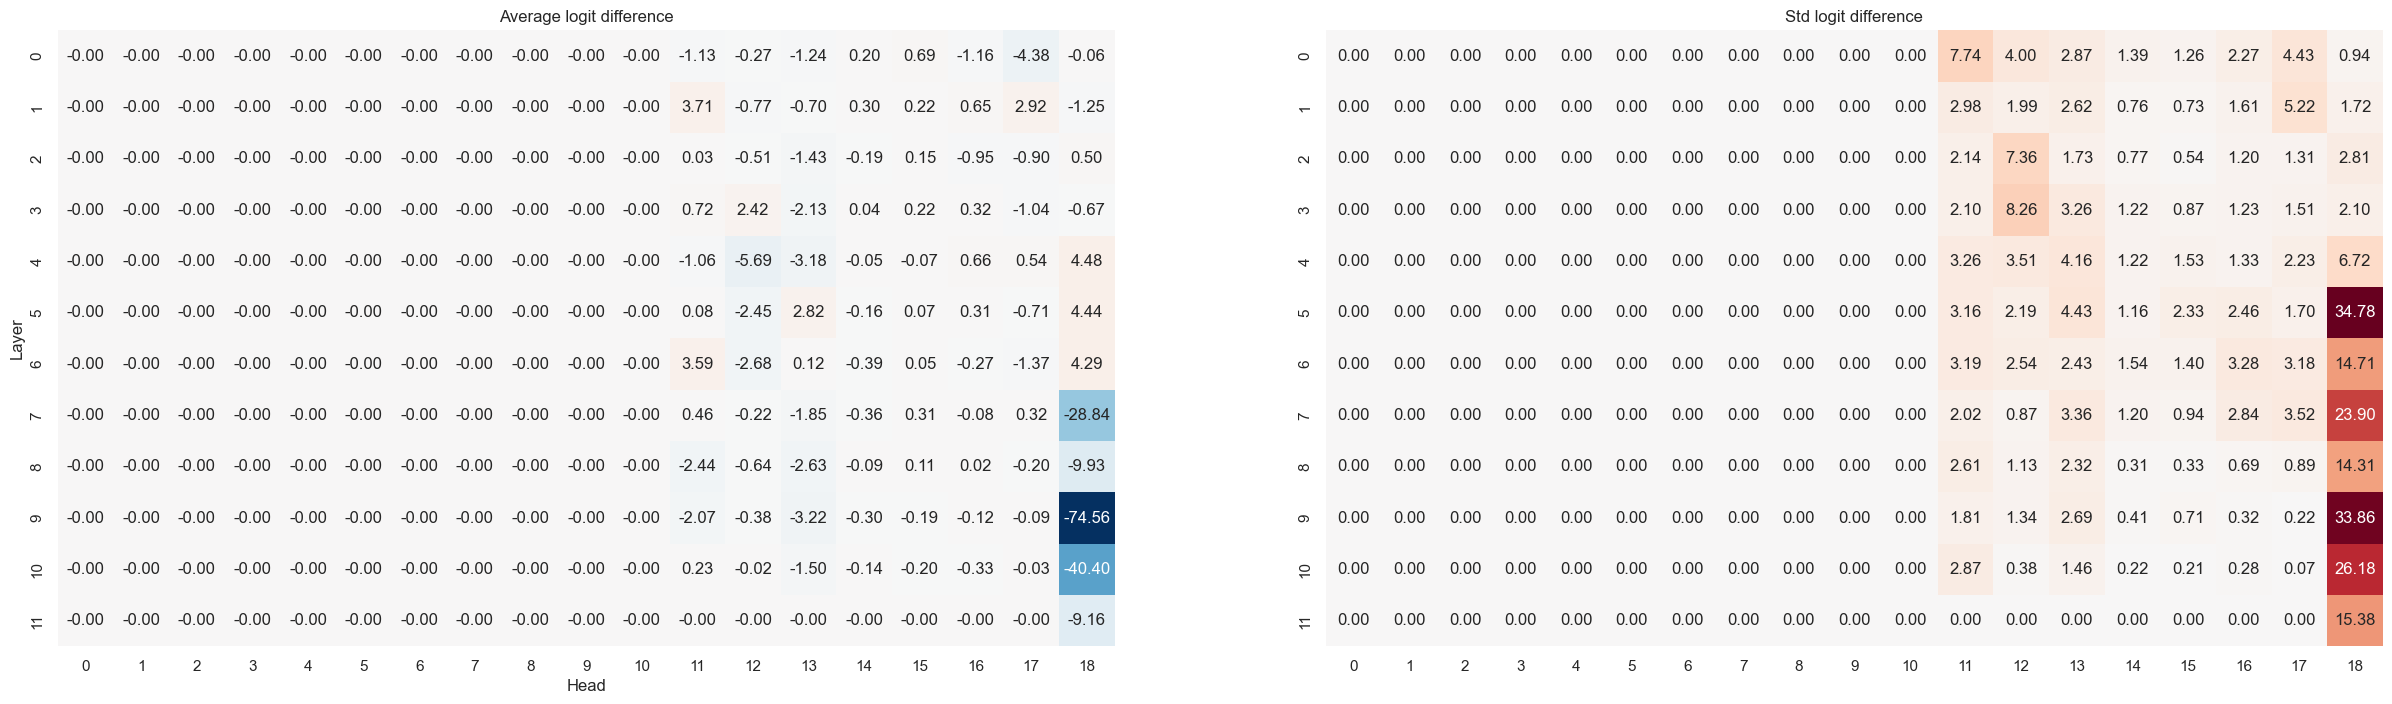

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(30, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=0.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:59<00:00,  4.96s/it]


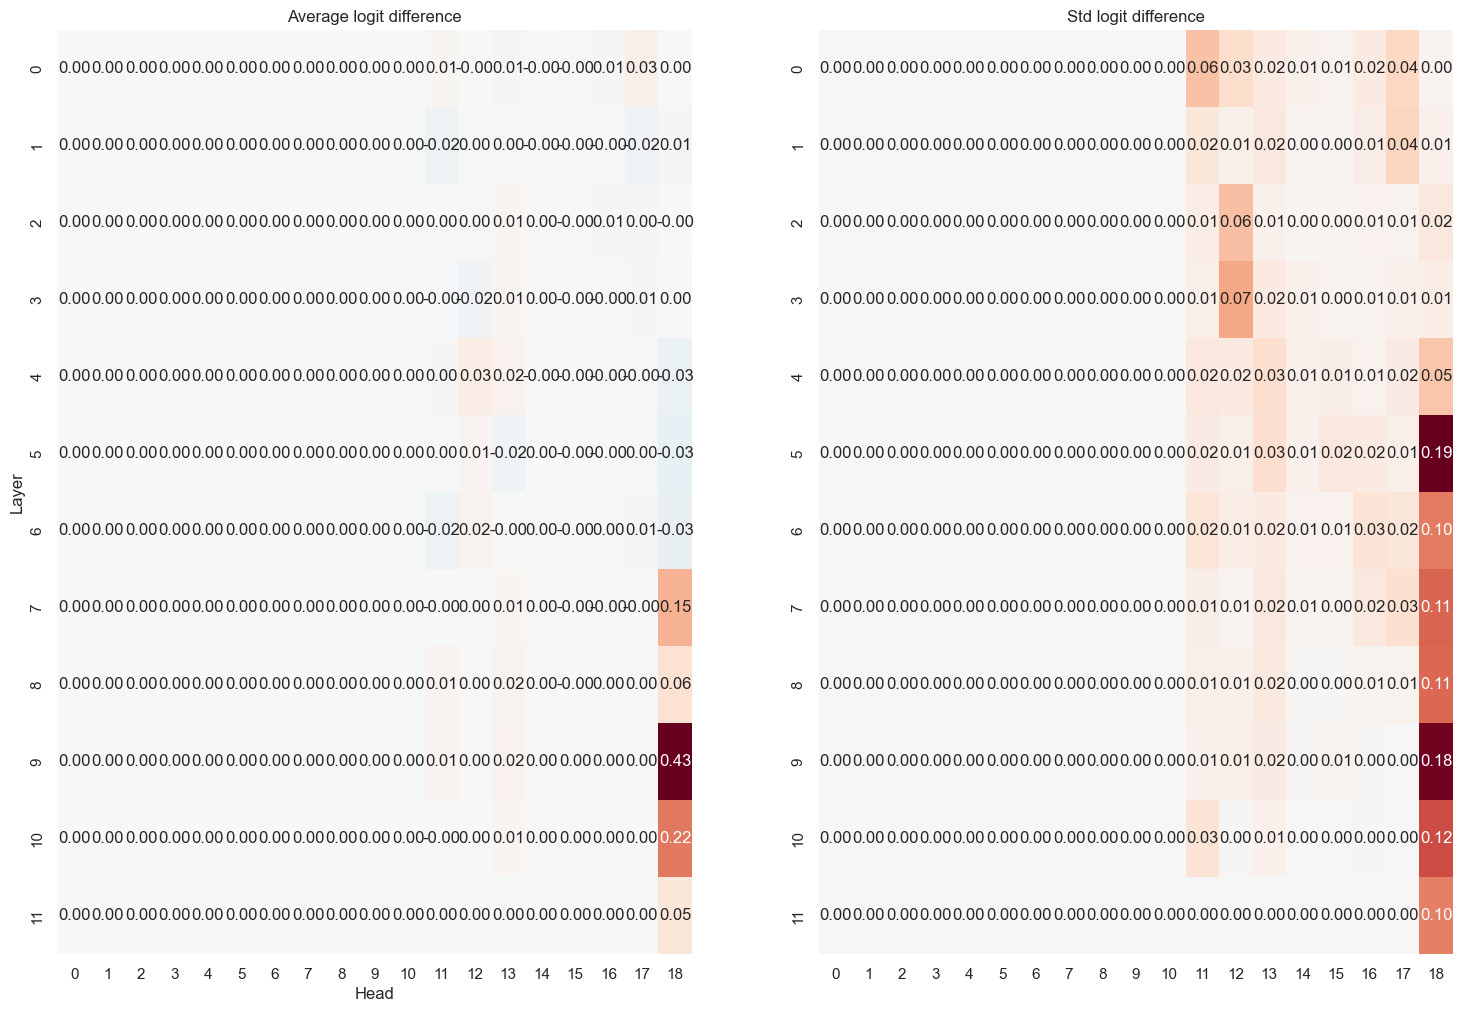

In [13]:
patching("attn")

100%|██████████| 12/12 [00:59<00:00,  4.95s/it]


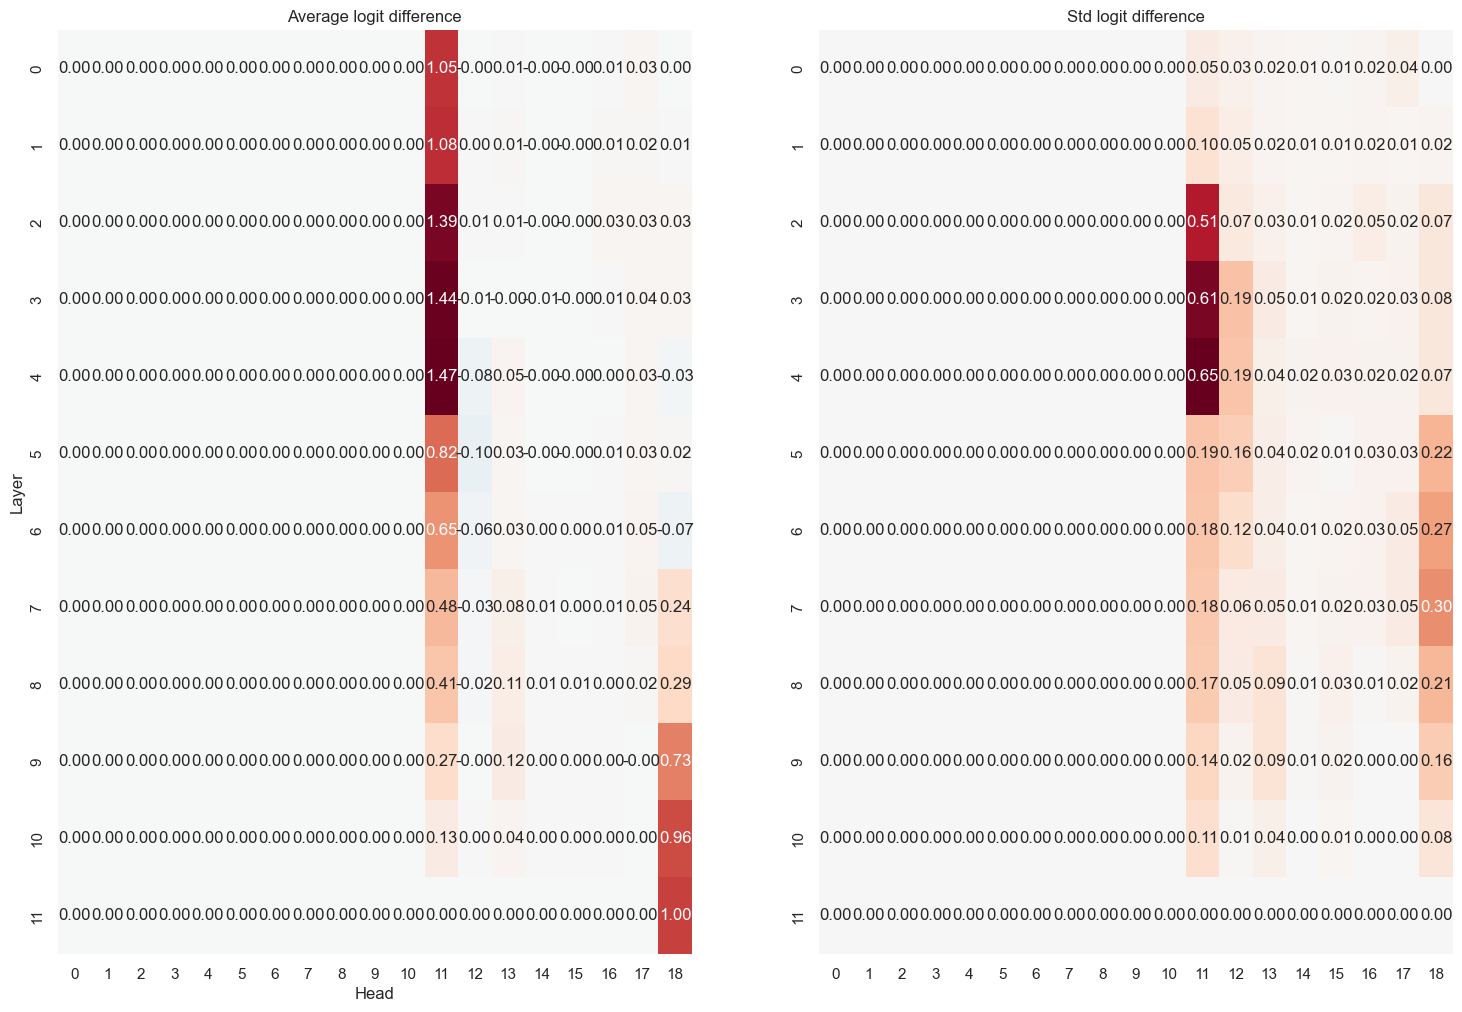

In [14]:
patching("resid_post")

In [39]:
mlp = f"blocks.10.hook_mlp_out"
attn = f"blocks.9.hook_attn_out"
resid_pre = f"blocks.1.hook_resid_pre"

corrupted_logit, corrupted_cache = model.run_with_cache(dataset.corrupted_prompts[0])
clean_logit, clean_cache = model.run_with_cache(dataset.clean_prompts[0])

In [20]:
corrupted_cache[mlp][:,-1,:].shape

torch.Size([1, 768])

In [56]:
def out_hook(activation, hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

patched_logit = model.run_with_hooks(
    dataset.clean_prompts[0],
    fwd_hooks=[(mlp, partial(out_hook, pos=-1, clean_activation=corrupted_cache[mlp]))],
)[:,-1,:]
print(patched_logit[0,target[0,0]])

tensor(13.2128, device='cuda:0')


tensor(13.2128, device='cuda:0')

In [ ]:
# patch attention head
from functools import partial
from tqdm import tqdm

def patching(hook:str):
    assert hook in ["mlp", "attn", "resid_pre", "resid_post", "resid_mid"], "hook must be one of mlp, attn, resid_pre, resid_post, resid_mid"
    hook = "attn"
    if hook in ["mlp", "attn"]:
        hook_name = f"hook_{hook}_out"
    else:
        hook_name = f"hook_{hook}"
    def out_hook(activation, hook, pos, clean_activation):
        activation[:, pos, :] = clean_activation[:, pos, :]
        return activation

    result = torch.zeros((model.cfg.n_layers, 19))
    result_std = torch.zeros((model.cfg.n_layers, 19))
    for layer in tqdm(range(model.cfg.n_layers), total=model.cfg.n_layers):
        for pos in range(19):
            logit_diff = torch.zeros(num_batches, batch_size)
            for idx, batch in enumerate(dataloader):
                corrupted_logit, corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])
                hook = partial(out_hook, pos=pos, clean_activation=corrupted_cache[f"blocks.{layer}.{hook_name}"])
                logit = model.run_with_hooks(
                    batch["clean_prompts"],
                    fwd_hooks=[(f"blocks.{layer}.{hook_name}", hook)],
                )[:,-1,:]

                logit_diff[idx,:] = to_logit_dif(logit, batch["target"])
            
            logit_diff = logit_diff.flatten()
            avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
            result[layer, pos] = avg_logit_diff
            result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)

    # plot the result as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()
    sns.set_style("whitegrid", {"axes.grid": False})
    # add also the std heatmap
    fig, ax = plt.subplots(1, 2, figsize=(18, 12))
    ax[0].set_title("Average logit difference")
    ax[1].set_title("Std logit difference")
    # make the center of the heatmap 0 and white color
    sns.heatmap(
        result.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[0],
        center=0.0,
        cmap="RdBu_r",
    )
    # label the axes
    ax[0].set_xlabel("Head")
    ax[0].set_ylabel("Layer")
    sns.heatmap(
        result_std.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[1],
        center=0.0,
        cmap="RdBu_r",
    )

In [27]:
# patch attention head
from functools import partial
from tqdm import tqdm

def ablating(hook:str):
    assert hook in ["mlp", "attn", "resid_pre", "resid_post", "resid_mid"], "hook must be one of mlp, attn, resid_pre, resid_post, resid_mid"
    hook = "attn"
    if hook in ["mlp", "attn"]:
        hook_name = f"hook_{hook}_out"
    else:
        hook_name = f"hook_{hook}"
    def out_hook(activation, hook, pos):
        activation[:, pos, :] = 0
        return activation

    result = torch.zeros((model.cfg.n_layers, 19))
    result_std = torch.zeros((model.cfg.n_layers, 19))
    for layer in tqdm(range(model.cfg.n_layers), total=model.cfg.n_layers):
        for pos in range(19):
            logit_diff = torch.zeros(num_batches, batch_size)
            for idx, batch in enumerate(dataloader):
                hook = partial(out_hook, pos=pos)
                logit = model.run_with_hooks(
                    batch["clean_prompts"],
                    fwd_hooks=[(f"blocks.{layer}.{hook_name}", hook)],
                )[:,-1,:]

                logit_diff[idx,:] = to_logit_dif(logit, batch["target"])
            
            logit_diff = logit_diff.flatten()
            avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
            result[layer, pos] = avg_logit_diff
            result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)

    # plot the result as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()
    sns.set_style("whitegrid", {"axes.grid": False})
    # add also the std heatmap
    fig, ax = plt.subplots(1, 2, figsize=(15, 12))
    ax[0].set_title("Average logit difference")
    ax[1].set_title("Std logit difference")
    # make the center of the heatmap 0 and white color
    sns.heatmap(
        result.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[0],
        center=0.0,
        cmap="RdBu_r",
    )
    # label the axes
    ax[0].set_xlabel("Head")
    ax[0].set_ylabel("Layer")
    sns.heatmap(
        result_std.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[1],
        center=0.0,
        cmap="RdBu_r",
    )

In [145]:
def get_mem_copy_probs(logit, target):
    logit = torch.softmax(logit, dim=-1)
    logit_true = torch.zeros(len(my_data))
    logit_copy = torch.zeros(len(my_data))
    for i in range(len(my_data)):
        logit_true[i] = logit[i, target[i,0]]
        logit_copy[i] = logit[i, target[i,1]]
    return logit_true, logit_copy

In [103]:
logit_true_base

tensor([3.2308e-03, 1.3263e-05, 2.4864e-01, 2.0442e-03, 2.3150e-02, 3.9353e-02,
        1.4920e-02, 4.9165e-06, 2.1284e-03, 3.2902e-02, 2.3793e-03, 2.0674e-01,
        3.6894e-03, 3.0132e-02, 8.3809e-03, 3.3054e-01, 3.7958e-02, 1.2546e-02,
        3.9576e-03, 4.1742e-02, 1.2194e-01, 1.2985e-01, 5.0838e-02, 2.6951e-02,
        1.1492e-02, 2.3264e-01, 1.1111e-04, 8.3883e-02, 5.5448e-02, 5.0849e-02,
        6.0737e-02, 1.2294e-01, 1.1487e-06, 9.5940e-06, 8.5653e-03, 2.2207e-04,
        2.8319e-03, 4.7967e-04, 8.1008e-03, 3.5703e-02, 3.7365e-04, 6.3211e-02,
        1.5737e-02, 5.1289e-02, 6.1045e-02, 1.0484e-01, 6.6328e-02, 3.9020e-03,
        4.7425e-02, 4.3451e-02])

In [107]:
base_logit_true 

tensor([ -5.7350, -11.2305,  -1.3917,  -6.1927,  -3.7658,  -3.2352,  -4.2050,
        -12.2229,  -6.1524,  -3.4142,  -6.0409,  -1.5763,  -5.6023,  -3.5022,
         -4.7818,  -1.1070,  -3.2713,  -4.3783,  -5.5321,  -3.1762,  -2.1042,
         -2.0413,  -2.9791,  -3.6137,  -4.4661,  -1.4582,  -9.1049,  -2.4783,
         -2.8923,  -2.9789,  -2.8012,  -2.0960, -13.6769, -11.5544,  -4.7600,
         -8.4125,  -5.8668,  -7.6424,  -4.8158,  -3.3325,  -7.8922,  -2.7613,
         -4.1517,  -2.9703,  -2.7961,  -2.2553,  -2.7131,  -5.5462,  -3.0486,
         -3.1361])

In [91]:
base_logit_true, base_logit_copy = get_mem_copy_probs(corrupted_logit, target)

In [15]:
base_logit_true.mean()

tensor(0.1918)

In [146]:
def change_in_prediction(logit_true, logit_copy, base_logit_true, base_logit_copy):
    true_change = (logit_true - base_logit_true) / (base_logit_true + 1e-8)
    copy_change = (logit_copy - base_logit_copy) / (base_logit_copy + 1e-8)
    return true_change, copy_change

In [80]:
change_in_prediction(base_logit_true, base_logit_copy)

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [21]:
true_tmp

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 true_tmp                                                                                     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'true_tmp' is not defined

In [51]:
# patch attention head
from functools import partial
from tqdm import tqdm

def blocking_attention():
    hook_name = "attn.hook_pattern"
    def out_hook(activation, hook, pos):
        activation[:, :, -1, pos] = 0
        return activation


    result_true = torch.zeros((model.cfg.n_layers, 15))
    result_true_std = torch.zeros((model.cfg.n_layers, 15))
    result_copy = torch.zeros((model.cfg.n_layers, 15))
    result_copy_std = torch.zeros((model.cfg.n_layers, 15))
    for layer in tqdm(range(model.cfg.n_layers), total=model.cfg.n_layers):
        for pos in range(15):
            logit_true = torch.zeros((num_batches, batch_size))
            logit_copy = torch.zeros((num_batches, batch_size))
            for idx, batch in enumerate(dataloader):
                hook = partial(out_hook, pos=pos)
                logit = model.run_with_hooks(
                    batch["corrupted_prompts"],
                    fwd_hooks=[(f"blocks.{layer}.{hook_name}", hook)],
                )[:,-1,:]

                true_tmp, copy_tmp = get_mem_copy_probs(logit, batch["target"])
                logit_true[idx,:] = true_tmp.cpu()
                logit_copy[idx,:] = copy_tmp.cpu()
            logit_true = logit_true.flatten()
            logit_copy = logit_copy.flatten()
            # logit_diff = logit_diff.flatten()
            # avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
            tmp_true, tmp_copy = change_in_prediction(logit_true, logit_copy)
            result_true[layer, pos] = tmp_true.mean(0)
            result_copy[layer, pos] = tmp_copy.mean(0)
            result_true_std[layer, pos] = tmp_true.std(0)
            result_copy_std[layer, pos] = tmp_copy.std(0)
            # result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)
    return result_true, result_copy, result_true_std, result_copy_std
    # plot the result as a heatmap
result_true, result_copy, result_true_std, result_copy_std = blocking_attention()
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set()
# sns.set_style("whitegrid", {"axes.grid": False})
# # add also the std heatmap
# fig, ax = plt.subplots(1, 2, figsize=(15, 8))
# ax[0].set_title("Average logit difference")
# ax[1].set_title("Std logit difference")
# # make the center of the heatmap 0 and white color
# sns.heatmap(
#     result_true.detach().cpu().numpy(),
#     annot=True,
#     fmt=".2f",
#     cbar=False,
#     ax=ax[0],
#     center=0.0,
#     cmap="RdBu_r",
# )
# # label the axes
# ax[0].set_xlabel("Head")
# ax[0].set_ylabel("Layer")
# sns.heatmap(
#     result_copy.detach().cpu().numpy(),
#     annot=True,
#     fmt=".2f",
#     cbar=False,
#     ax=ax[1],
#     center=0.0,
#     cmap="RdBu_r",
# )
    

100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


In [54]:
result_true[:,7]

tensor([ 2.1653e-02,  7.5030e-04,  9.3198e-03,  1.6992e-02,  1.0133e-02,
         8.0815e-02,  2.2596e-01,  9.0765e-01, -2.8148e-01,  1.4416e-01,
         4.6903e-01, -1.5012e-01])

In [53]:
result_true_std[:,7]

tensor([0.0964, 0.0455, 0.0173, 0.0329, 0.0436, 0.7832, 0.3817, 2.0730, 0.2702,
        0.4766, 1.1626, 0.3048])

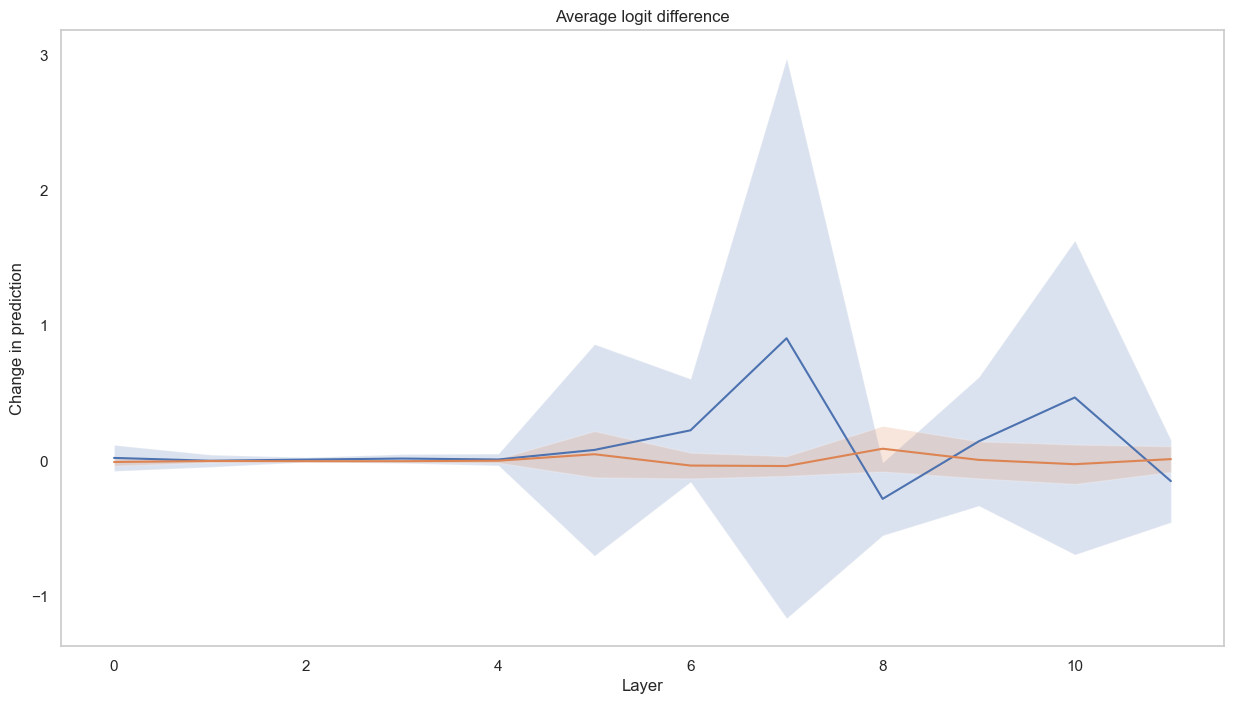

In [60]:


## plot a line plot for each position with x-ax the layer and y-ax the change in prediction
import matplotlib.pyplot as plt
import seaborn as sns
x_values = np.arange(len(result_true[:, 7]))
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.set_title("Average logit difference")
ax.set_xlabel("Layer")
ax.set_ylabel("Change in prediction")
ax.plot(result_true[:,7].detach().cpu().numpy(), label="True")
## add the std
ax.fill_between(x_values, result_true[:,7].detach().cpu().numpy() - result_true_std[:,7].detach().cpu().numpy(), result_true[:,7].detach().cpu().numpy() + result_true_std[:,7].detach().cpu().numpy(), alpha=0.2)
ax.plot(result_copy[:,7].detach().cpu().numpy(), label="True")
ax.fill_between(x_values, result_copy[:,7].detach().cpu().numpy() - result_copy_std[:,7].detach().cpu().numpy(), result_copy[:,7].detach().cpu().numpy() + result_copy_std[:,7].detach().cpu().numpy(), alpha=0.2)
plt.show()

## resid

In [58]:
clean_prompts = [d["template"].format(model.tokenizer.pad_token) for d in my_data]
corrupted_prompts = [d["template"].format(d["target_new"]) for d in my_data]
target_new = [d["target_new"] for d in my_data]
target_true = [d["target_true"] for d in my_data]



In [57]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation, hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 15))
result_std = torch.zeros((model.cfg.n_layers, 15))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(15):
        hook = partial(out_hook, pos=pos, clean_activation=corrupted_cache[f"blocks.{layer}.hook_resid_post"])
        logit = model.run_with_hooks(
            clean_prompts,
            fwd_hooks=[(f"blocks.{layer}.hook_resid_post", hook)],
        )
        logit_diff = to_logit_dif(logit, target)
        result[layer,pos] = normalize_logit_diff(logit_diff).mean(dim=0)
        result_std[layer,pos] = normalize_logit_diff(logit_diff).std(dim=0)
        # result[layer, pos] = logit_diff.mean(dim=0)
        # result_std[layer, pos] = logit_diff.std(dim=0)
        if (layer, pos) == (7, 14):
            layer7 = logit_diff
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=0.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



  0%|          | 0/12 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:18                                                                                   │
│                                                                                                  │
│   15 │   │   │   clean_prompts,                                                                  │
│   16 │   │   │   fwd_hooks=[(f"blocks.{layer}.hook_resid_post", hook)],                          │
│   17 │   │   )                                                                                   │
│ ❱ 18 │   │   logit_diff = to_logit_dif(logit, target)                                            │
│   19 │   │   result[layer,pos] = normalize_logit_diff(logit_diff).mean(dim=0)                    │
│   20 │   │   result_std[layer,pos] = normalize_logit_diff(logit_diff).std(dim=0)                 │
│   21 │   │   # result[layer, pos] = logit_diff.mean(dim=0)                                       │
│                                                                                                  │
│ in to_logit_dif:8                                                                                │
│                                                                                                  │
│    5 │   # so we need to index logit with target                                                 │
│    6 │   logit_diff = torch.zeros(target.shape[0])                                               │
│    7 │   for i in range(target.shape[0]):                                                        │
│ ❱  8 │   │   logit_diff[i] = logit[i, target[i,0]] - logit[i, target[i,1]]                       │
│    9 │   # print(logit_of_target.shape)                                                          │
│   10 │   # print(logit_of_target[:10])                                                           │
│   11 │   # # for each batch, we want to compute the difference between the two tokens in targ    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 5413 is out of bounds for dimension 1 with size 15

100%|██████████| 12/12 [00:18<00:00,  1.58s/it]


<Axes: title={'center': 'Std logit difference'}>

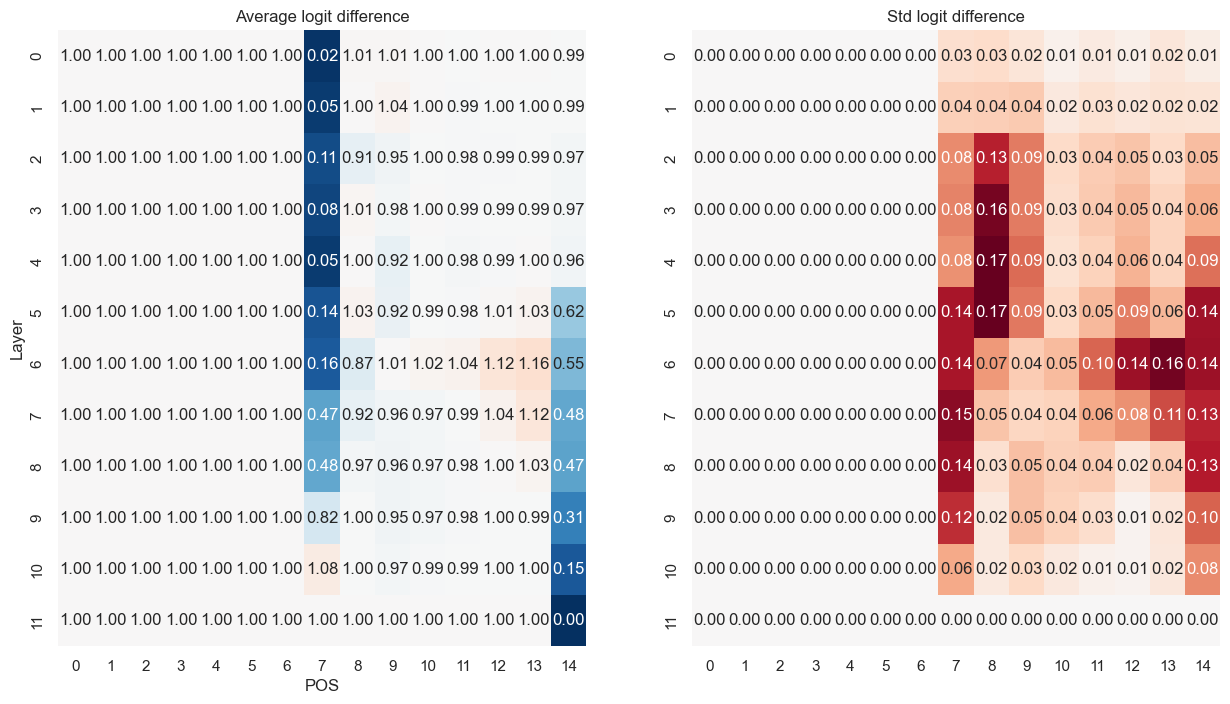

In [27]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation, hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 15))
result_std = torch.zeros((model.cfg.n_layers, 15))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(15):
        hook = partial(out_hook, pos=pos, clean_activation=clean_cache[f"blocks.{layer}.hook_resid_post"])
        logit = model.run_with_hooks(
            corrupted_prompts,
            fwd_hooks=[(f"blocks.{layer}.hook_resid_post", hook)],
        )
        logit_diff = to_logit_dif(logit, target)
        result[layer,pos] = normalize_logit_diff(logit_diff).mean(dim=0)
        result_std[layer,pos] = normalize_logit_diff(logit_diff).std(dim=0)
        # result[layer, pos] = logit_diff.mean(dim=0)
        # result_std[layer, pos] = logit_diff.std(dim=0)
        if (layer, pos) == (7, 14):
            layer7 = logit_diff
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=1.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



100%|██████████| 12/12 [03:45<00:00, 18.81s/it]


<Axes: title={'center': 'Std logit difference'}>

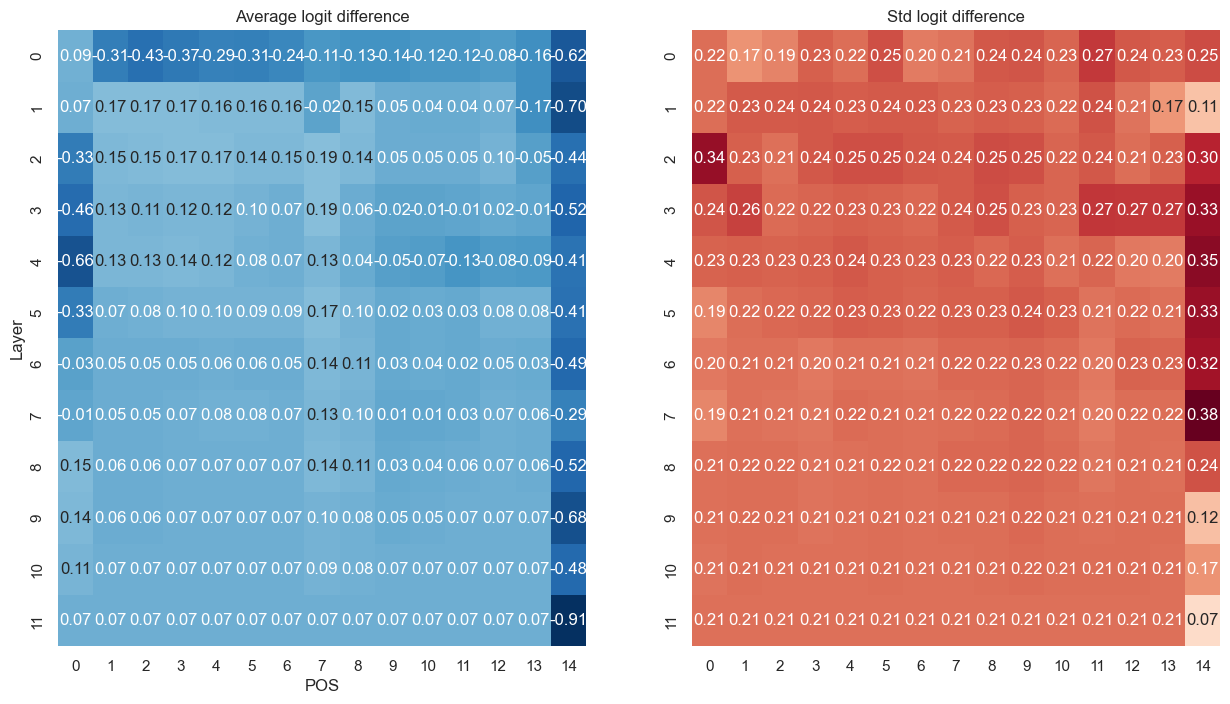

In [17]:
#patch attention head
from functools import partial
from tqdm import tqdm

logit_corrupted_full = model(corrupted_prompts)
base_logit_true, base_logit_copy = get_mem_copy_probs(logit_corrupted_full, target)


def out_hook(activation, hook, pos):
    activation[:, pos, :] = 0
    return activation

result = torch.zeros((model.cfg.n_layers, 15))
result_std = torch.zeros((model.cfg.n_layers, 15))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(15):
        hook = partial(out_hook, pos=pos)
        logit = model.run_with_hooks(
            clean_prompts,
            fwd_hooks=[(f"blocks.{layer}.hook_resid_post", hook)],
        )
        logit_true, logit_copy = get_mem_copy_probs(logit, target)
        # logit_diff = to_logit_dif(logit, target)
        result[layer,pos] = (logit_true/base_logit_true -1 ).mean()
        result_std[layer,pos] = (logit_true/base_logit_true -1 ).std()
        # result[layer, pos] = logit_diff.mean(dim=0)
        # result_std[layer, pos] = logit_diff.std(dim=0)
        if (layer, pos) == (7, 14):
            layer7 = logit_diff
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=1.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



In [106]:
import circuitsvis as cv
cv.attention.attention_patterns(model.to_str_tokens(clean_prompts[0]), clean_cache["pattern",5][0], )

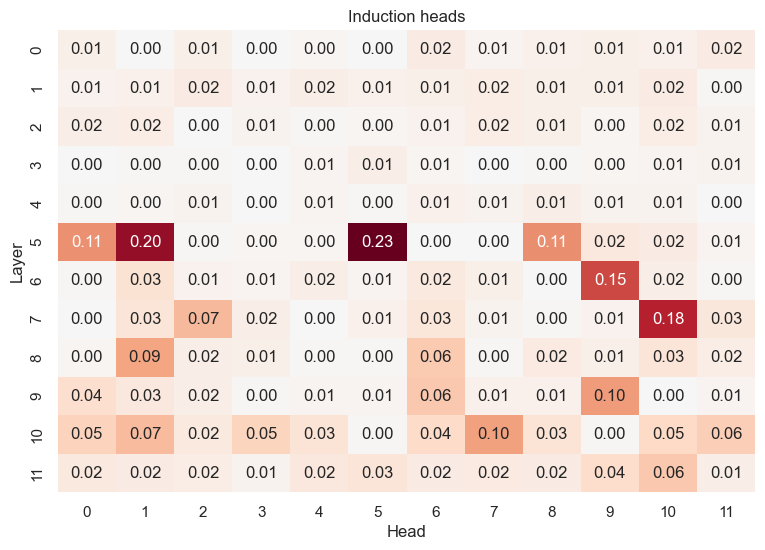

In [19]:
import transformer_lens as tl
batch = next(iter(dataloader))
induction_heads = tl.head_detector.detect_head(model=model,seq=batch["corrupted_prompts"], detection_pattern="induction_head")
#plot induction heads
plt.figure(figsize=(9,6))
sns.heatmap(induction_heads, annot=True, fmt=".2f", cbar=False, center=0.0, cmap="RdBu_r")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.title("Induction heads")
plt.show()

In [17]:
import transformer_lens as tl
induction_heads = tl.head_detector.detect_head(model=model,seq=clean_prompts, detection_pattern="induction_head")
#plot induction heads
plt.figure(figsize=(9,6))
sns.heatmap(induction_heads, annot=True, fmt=".2f", cbar=False, center=0.0, cmap="RdBu_r")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.title("Induction heads")
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 import transformer_lens as tl                                                               │
│ ❱  2 induction_heads = tl.head_detector.detect_head(model=model,seq=clean_prompts, detection_    │
│    3 #plot induction heads                                                                       │
│    4 plt.figure(figsize=(9,6))                                                                   │
│    5 sns.heatmap(induction_heads, annot=True, fmt=".2f", cbar=False, center=0.0, cmap="RdBu_r    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'clean_prompts' is not defined

In [69]:
target.shape

torch.Size([50, 2])

tensor(0.0084) tensor(0.0775) tensor(0.0017) tensor(0.0159)


/tmp/ipykernel_30080/811080935.py:43: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cp, kde=True)


Text(0, 0.5, 'Frequency')

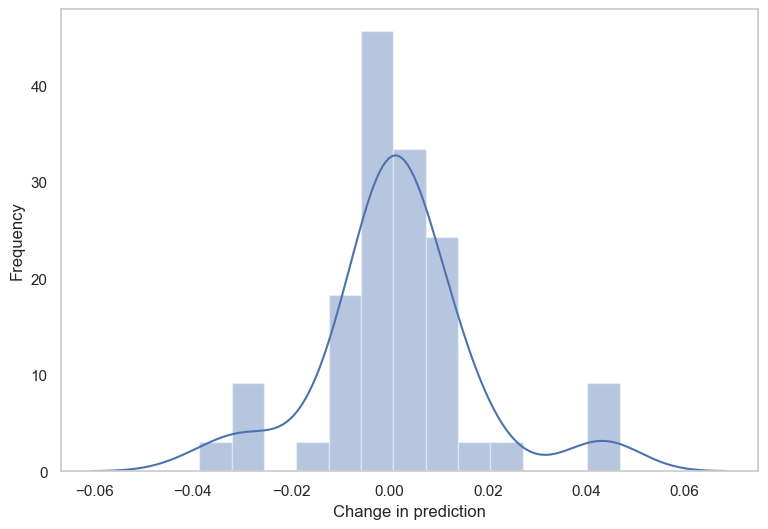

In [162]:
# patch attention head
from functools import partial
from tqdm import tqdm

batch = next(iter(dataloader))
logit = model.run_with_hooks(batch["corrupted_prompts"])[:,-1,:]
logit_true_base , logit_copy_base = get_mem_copy_probs(logit, target)

result=0
def heads_hook(activation, hook, head, pos1=None, pos2=None):
    # activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    activation[:, head, -1, :] = 0
    return activation

def generate_hooks(heads):
    hooks = []
    for layer,head in heads:
        hooks.append(
            (f"blocks.{layer}.attn.hook_pattern", partial(heads_hook, head=head))
        )
    return hooks

heads = []
#generate random 6 heads
for i in range(6):
    layer = random.randint(0,11)
    head = random.randint(0,11)
    heads.append((layer, head))
hooks = generate_hooks(heads)
hooks = generate_hooks([(1,8)])
logit = model.run_with_hooks(batch["corrupted_prompts"], fwd_hooks=hooks)[:,-1,:]
logit_true, logit_copy = get_mem_copy_probs(logit, target)

tr, cp = change_in_prediction(logit_true, logit_copy, logit_true_base, logit_copy_base)
print(tr.mean(), tr.std(), cp.mean(), cp.std())

#plot cp distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(9,6))
sns.distplot(cp, kde=True)
plt.xlabel("Change in prediction")
plt.ylabel("Frequency")


In [58]:
pos

0

In [88]:
layer=11
torch.norm(corrupted_cache[f"blocks.{layer}.hook_attn_out"][:,-1,:], dim=-1) / torch.norm(corrupted_cache[f"blocks.{layer}.hook_resid_pre"][:,-1,:], dim=-1)

tensor([1.1604, 0.6906, 1.1322, 1.0775, 0.8628, 1.1833, 1.1157, 0.6951, 1.0873,
        1.1952, 1.1723, 0.9632, 1.2376, 1.0896, 1.1027, 1.0067, 1.1053, 1.0314,
        1.1129, 0.9459, 1.1066, 1.0236, 1.0778, 1.0943, 0.9004, 1.0145, 1.1606,
        0.9316, 0.9541, 1.0274, 1.0819, 1.1161, 0.8550, 0.7854, 1.1523, 0.7117,
        0.7296, 1.1689, 1.0654, 1.0544, 1.0535, 1.1831, 1.2421, 0.9083, 0.9930,
        1.0112, 1.0107, 1.1084, 1.0097, 1.0679], device='cuda:0')

In [65]:
torch.norm(corrupted_cache[f"blocks.{layer}.hook_resid_pre"][:,-1,:], dim=-1)

tensor([82.5491, 72.2929, 82.6806, 81.6841, 79.6141, 83.1664, 75.3628, 69.3134,
        80.3219, 83.5886, 77.6442, 82.6200, 75.3503, 82.6346, 79.1550, 81.6876,
        92.1994, 80.5246, 82.4122, 75.5104, 79.3406, 82.1013, 77.2391, 80.4901,
        75.2760, 82.0790, 79.6367, 75.3595, 86.6334, 76.6378, 84.4222, 76.0398,
        83.1462, 77.5139, 81.3993, 74.4453, 77.7489, 78.7548, 82.1326, 82.0063,
        78.1368, 77.8822, 85.6480, 80.7767, 81.5513, 82.4098, 74.8899, 78.4015,
        81.2829, 81.5502], device='cuda:0')

In [90]:
torch.norm(corrupted_cache[f"blocks.{layer}.hook_resid_mid"][:,-1,:], dim=-1).shape

torch.Size([50])

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


<Axes: title={'center': 'Std logit difference'}>

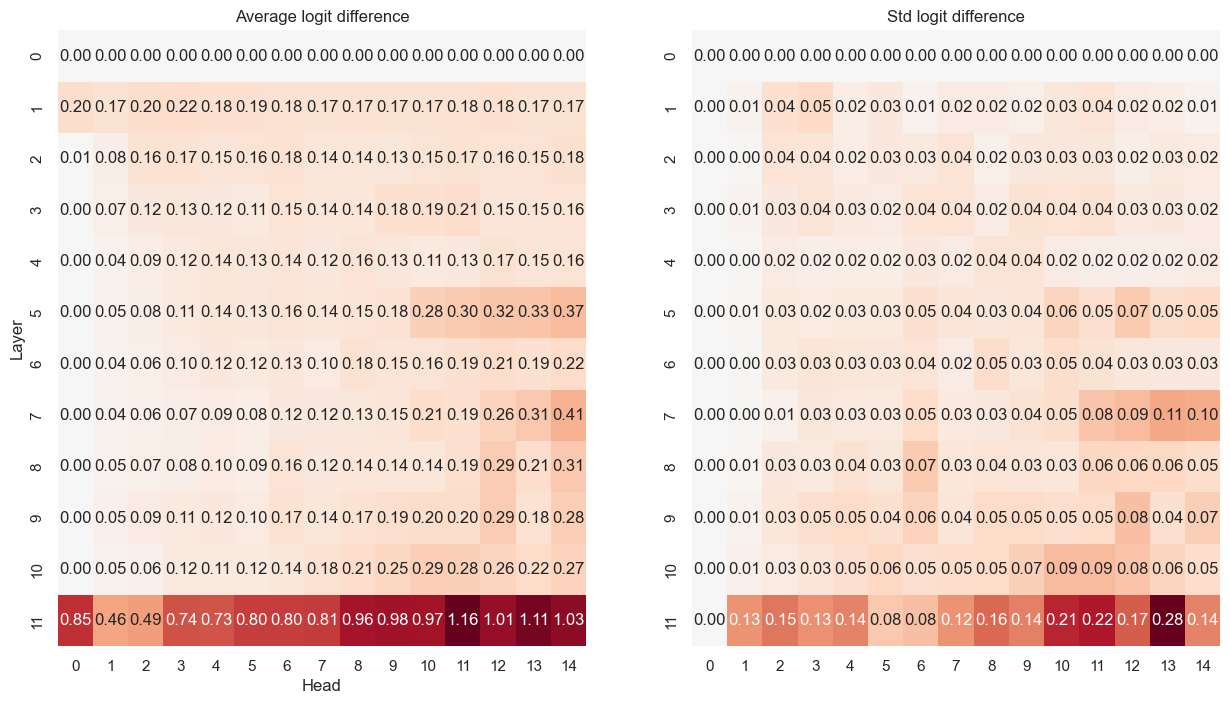

In [107]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, :, :] = clean_activation[:, head, :, :]
    return activation


result = torch.zeros((model.cfg.n_layers, 15))
result_std = torch.zeros((model.cfg.n_layers , 15))

for layer in tqdm(range(1,model.cfg.n_layers)):
    for pos in range(15):
        norm = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(
                batch["corrupted_prompts"]
            )
            norm[idx] = (torch.norm(
                corrupted_cache[f"blocks.{layer}.hook_attn_out"][:, pos, :], dim=-1
            ) / torch.norm(
                corrupted_cache[f"blocks.{layer}.hook_resid_pre"][:, pos, :], dim=-1
            ))



        norm = norm.flatten()
        result[layer, pos] = norm.mean()
        result_std[layer, pos] = norm.std()

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=0.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:35<00:00,  2.95s/it]


<Axes: title={'center': 'Std logit difference'}>

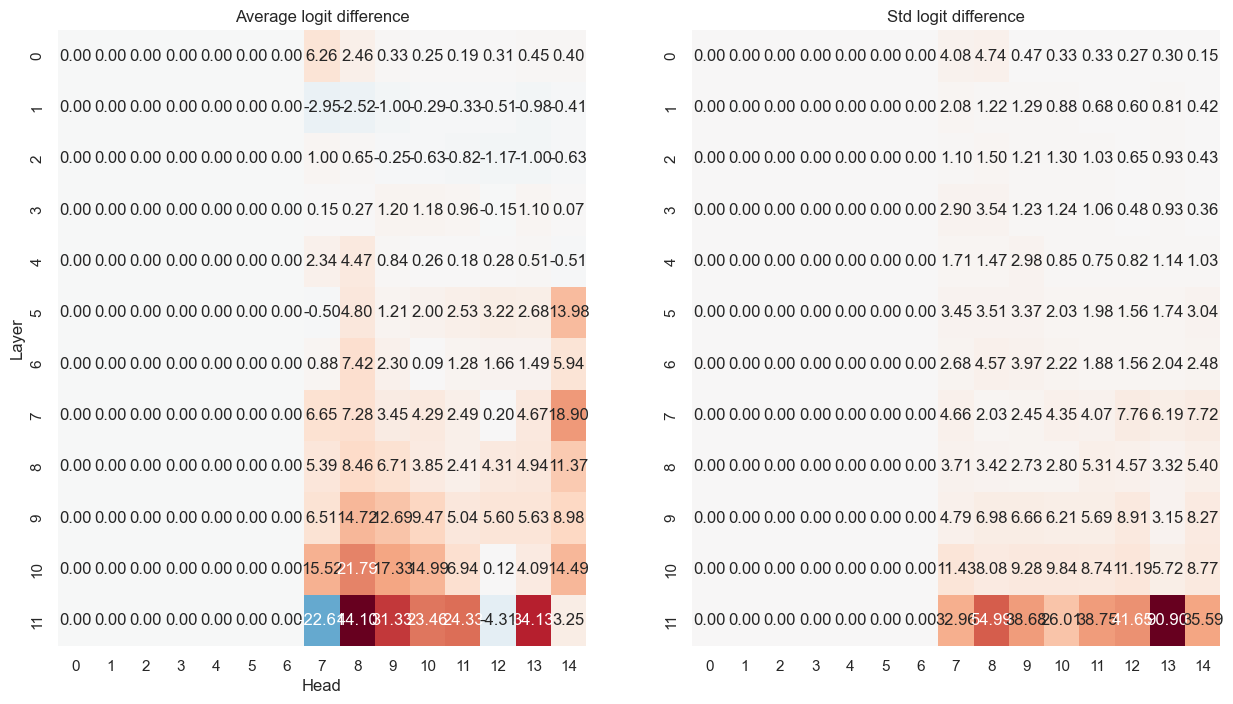

In [109]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, :, :] = clean_activation[:, head, :, :]
    return activation


result = torch.zeros((model.cfg.n_layers, 15))
result_std = torch.zeros((model.cfg.n_layers , 15))

for layer in tqdm(range(0,model.cfg.n_layers)):
    for pos in range(15):
        norm = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(
                batch["corrupted_prompts"]
            )
            clean_logit, clean_cache = model.run_with_cache(
                batch["clean_prompts"]
            )
            norm[idx] = (torch.norm(
                corrupted_cache[f"blocks.{layer}.hook_attn_out"][:, pos, :], dim=-1
            ) - torch.norm(
                clean_cache[f"blocks.{layer}.hook_attn_out"][:, pos, :], dim=-1
            ))



        norm = norm.flatten()
        result[layer, pos] = norm.mean()
        result_std[layer, pos] = norm.std()

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=0.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [29]:
def get_mem_copy_probs(logit, target):
    # logit = torch.log_softmax(logit, dim=-1)
    logit_true = torch.zeros(len(my_data))
    logit_copy = torch.zeros(len(my_data))
    for i in range(len(my_data)):
        logit_true[i] = logit[i, -1, target[i,0]]
        logit_copy[i] = logit[i, -1, target[i,1]]
    
    return logit_true, logit_copy

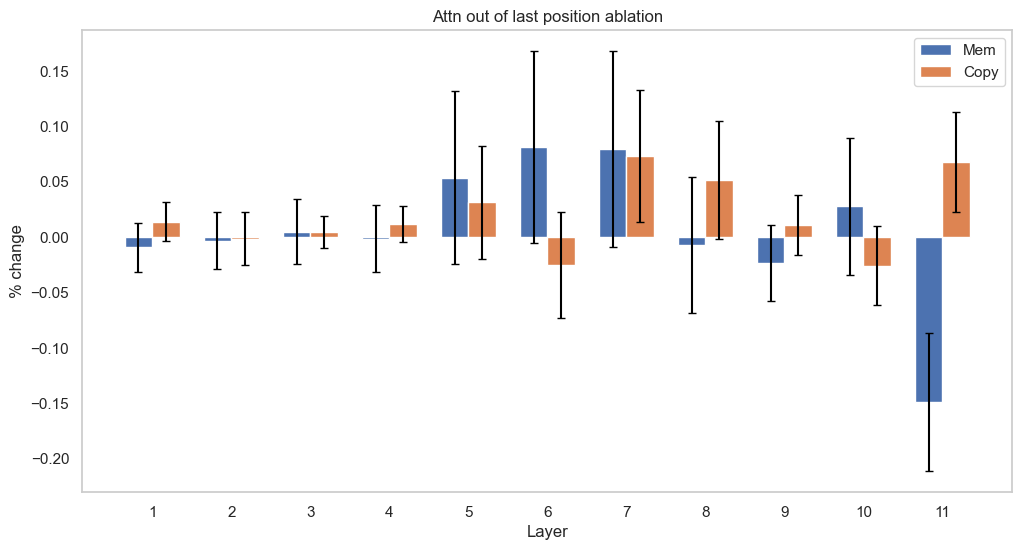

In [19]:
def ablate_attn_out(activation, hook, pos=-1):
    activation[:, pos, :] = 0
    return activation

logit_corrupted_full = model(corrupted_prompts)
base_logit_true, base_logit_copy = get_mem_copy_probs(logit_corrupted_full, target)

logit_true_abl = torch.zeros(model.cfg.n_layers -1)
logit_copy_abl = torch.zeros(model.cfg.n_layers -1)
logit_true_abl_std = torch.zeros(model.cfg.n_layers -1)
logit_copy_abl_std = torch.zeros(model.cfg.n_layers -1)

for layer in range(1, model.cfg.n_layers):
    logit_ablated = model.run_with_hooks(
        corrupted_prompts,
        fwd_hooks=[(f"blocks.{layer}.hook_attn_out", partial(ablate_attn_out, pos=-1))],
    )
    true, copy = get_mem_copy_probs(logit_ablated, target)
    logit_true_abl[layer-1], logit_copy_abl[layer-1] = (true / base_logit_true - 1).mean(), (1 - copy / base_logit_copy).mean()
    logit_true_abl_std[layer-1], logit_copy_abl_std[layer-1] = (true / base_logit_true - 1).std(), (1- copy / base_logit_copy).std()

# plot the result as a barplot with layers on the x axis
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of the bars
index = np.arange(11)  # The x locations for the groups

plt.bar(index, logit_true_abl, bar_width, label='Mem')
plt.bar(index + bar_width, logit_copy_abl, bar_width, label='Copy')
## add errorbar
plt.errorbar(index, logit_true_abl, yerr=logit_true_abl_std, fmt='none', color='black', capsize=3)
plt.errorbar(index + bar_width, logit_copy_abl, yerr=logit_copy_abl_std, fmt='none', color='black', capsize=3)
#plot horizontal line for base
# plt.axhline(base_logit_true.mean().detach().numpy(), color="blue", linestyle="--")
# add std
# plt.axhline(base_logit_copy.mean().detach().numpy(), color="orange", linestyle="--")

plt.xlabel('Layer')
plt.ylabel('% change') 
plt.title('Attn out of last position ablation')
plt.xticks(index + bar_width / 2, range(1, 12))  # Positioning the x-labels in the middle of grouped bars
plt.legend()

plt.show()

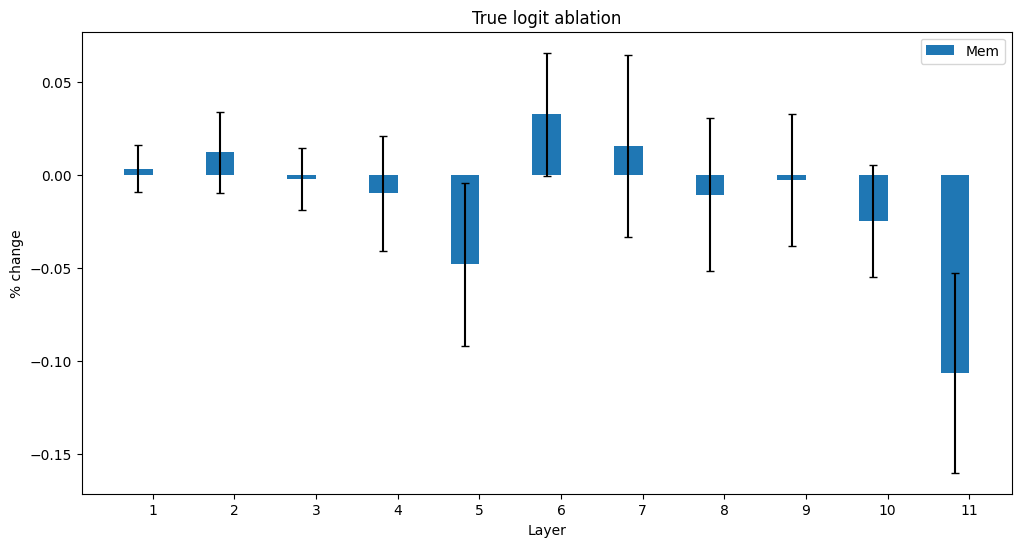

In [13]:
def ablate_attn_out(activation, hook, pos=-1):
    activation[:, pos, :] = 0
    return activation

logit_corrupted_full = model(clean_prompts)
base_logit_true, base_logit_copy = get_mem_copy_probs(logit_corrupted_full, target)

logit_true_abl = torch.zeros(model.cfg.n_layers -1)
logit_copy_abl = torch.zeros(model.cfg.n_layers -1)
logit_true_abl_std = torch.zeros(model.cfg.n_layers -1)
logit_copy_abl_std = torch.zeros(model.cfg.n_layers -1)

for layer in range(1, model.cfg.n_layers):
    logit_ablated = model.run_with_hooks(
        clean_prompts,
        fwd_hooks=[(f"blocks.{layer}.hook_attn_out", partial(ablate_attn_out, pos=-1))],
    )
    true, copy = get_mem_copy_probs(logit_ablated, target)
    logit_true_abl[layer-1], logit_copy_abl[layer-1] = (true / base_logit_true - 1).mean(), (1 - copy / base_logit_copy).mean()
    logit_true_abl_std[layer-1], logit_copy_abl_std[layer-1] = (true / base_logit_true - 1).std(), (1- copy / base_logit_copy).std()

# plot the result as a barplot with layers on the x axis
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.35  # Width of the bars
index = np.arange(11)  # The x locations for the groups

plt.bar(index, logit_true_abl, bar_width, label='Mem')
# plt.bar(index + bar_width, logit_copy_abl, bar_width, label='Copy')
## add errorbar
plt.errorbar(index, logit_true_abl, yerr=logit_true_abl_std, fmt='none', color='black', capsize=3)
# plt.errorbar(index + bar_width, logit_copy_abl, yerr=logit_copy_abl_std, fmt='none', color='black', capsize=3)
#plot horizontal line for base
# plt.axhline(base_logit_true.mean().detach().numpy(), color="blue", linestyle="--")
# add std
# plt.axhline(base_logit_copy.mean().detach().numpy(), color="orange", linestyle="--")

plt.xlabel('Layer')
plt.ylabel('% change') 
plt.title('True logit ablation')
plt.xticks(index + bar_width / 2, range(1, 12))  # Positioning the x-labels in the middle of grouped bars
plt.legend()

plt.show()

In [58]:
# patch attention head
from functools import partial
from tqdm import tqdm

logit = model.run_with_hooks(clean_prompts)
logit = torch.log_softmax(logit, dim=-1)
logit_true = torch.zeros(len(my_data))
logit_copy = torch.zeros(len(my_data))
for i in range(len(my_data)):
    logit_true[i] = logit[i, -1, target[i,0]]
    logit_copy[i] = logit[i, -1, target[i,1]]
# print("Logit true base", logit_true.mean(), logit_true.std())    
# print("Logit copy base", logit_copy.mean(), logit_copy.std())
prob_true_base = logit_true.mean()
prob_copy_base = logit_copy.mean()

def heads_hook(activation, hook, pos, pos1=None, pos2=None):
    # activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    activation[:, pos, :] = 0
    return activation

def generate_hooks(layer):
    hooks = []
    for l in layer:
        hooks.append(
            (f"blocks.{l}.hook_attn_out", partial(heads_hook, pos=-1))
        )
    return hooks

# hooks = []
# # generate random 6 heads
# import random

# heads = []
# for i in range(6):
#     heads.append((random.randint(0,11), random.randint(0,11)))
heads = [11]
hooks = generate_hooks(heads)
logit = model.run_with_hooks(clean_prompts, fwd_hooks=hooks)
logit_diff = to_logit_dif(logit, target)
logit = torch.log_softmax(logit, dim=-1)
logit_true = torch.zeros(len(my_data))
logit_copy = torch.zeros(len(my_data))
for i in range(len(my_data)):
    logit_true[i] = logit[i, -1, target[i,0]]
    logit_copy[i] = logit[i, -1, target[i,1]]
# print("Logit true", logit_true.mean(), logit_true.std())    
# print("Logit copy", logit_copy.mean(), logit_copy.std())

# change in percentage
print("Logit true over base",  prob_true_base / logit_true.mean())
print("Logit copy over base", prob_copy_base / logit_copy.mean())

# avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
# print(avg_logit_diff, logit_diff.mean(), logit_diff.std())



Logit true over base tensor(0.6300)
Logit copy over base tensor(0.9853)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


<Axes: title={'center': 'Std logit difference'}>

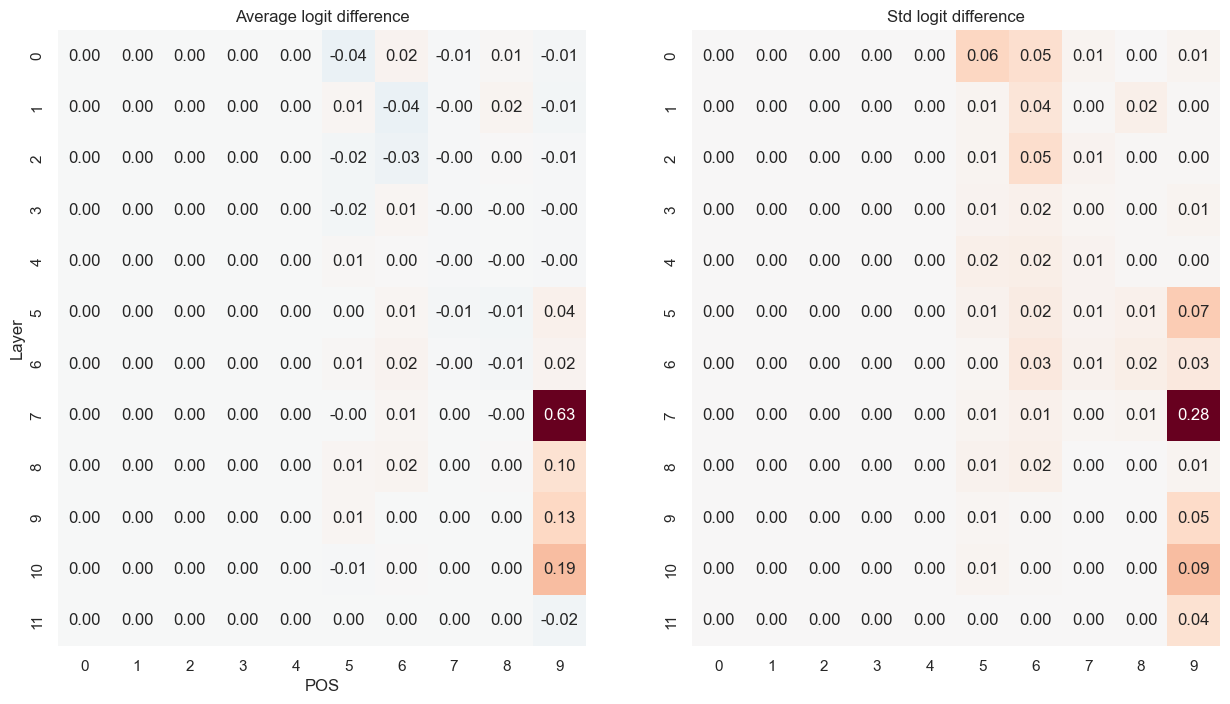

In [27]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation,hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 10))
result_std = torch.zeros((model.cfg.n_layers, 10))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(10):
        hook = partial(out_hook, pos=pos)
        logit = run_with_hooks(model, clean_prompts, hooks=[f"blocks.{layer}.hook_attn_out", hook], activations=[cache[f"blocks.{layer}.hook_attn_out"] for cache in corrupted_cache])
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer, pos] = avg_logit_diff
        result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)
        
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=0.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


<Axes: title={'center': 'Std logit difference'}>

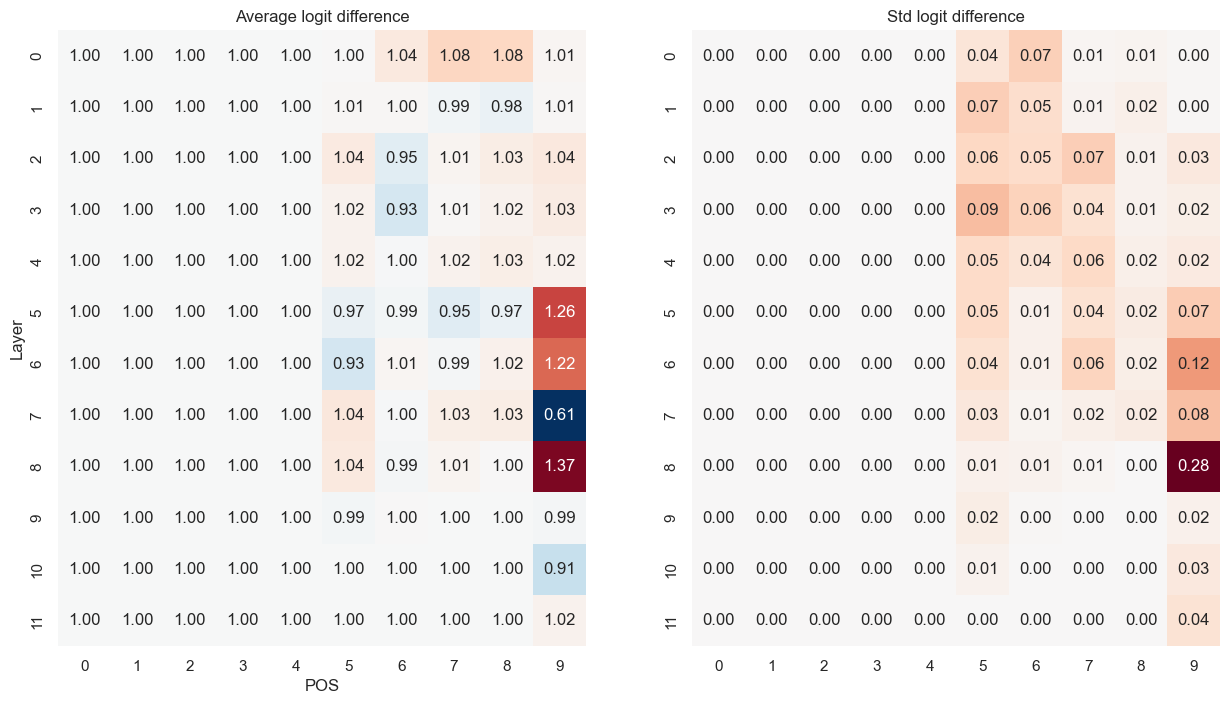

In [106]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation,hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 10))
result_std = torch.zeros((model.cfg.n_layers, 10))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(10):
        hook = partial(out_hook, pos=pos)
        logit = run_with_hooks(model, corrupted_prompts, hooks=[f"blocks.{layer}.hook_attn_out", hook], activations=[cache[f"blocks.{layer}.hook_attn_out"] for cache in clean_cache])
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer, pos] = avg_logit_diff
        result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)
        
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=1.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



In [51]:
import circuitsvis as cv
batch = next(iter(dataloader))
logit, cache = model.run_with_cache(batch["clean_prompts"][0])
cv.attention.attention_patterns(model.to_str_tokens(batch["clean_prompts"][0]), cache["pattern",9][0])

In [52]:
import circuitsvis as cv
batch = next(iter(dataloader))
logit, cache = model.run_with_cache(batch["corrupted_prompts"][0])
cv.attention.attention_patterns(model.to_str_tokens(batch["corrupted_prompts"][0]), cache["pattern",9][0])

In [27]:
import circuitsvis as cv
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[1]), corrupted_cache["pattern",7][1], )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import circuitsvis as cv                                                                     │
│ ❱ 2 cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[1]), corrupted_cac     │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'corrupted_prompts' is not defined

In [42]:
model.blocks[7].attn.W_O.shape

torch.Size([12, 64, 768])

In [43]:
corrupted_cache["pattern",7].shape

torch.Size([3, 12, 10, 10])

In [34]:
import einops
output = einops.einsum(corrupted_cache["pattern",7][:,7], model.blocks[7].attn.W_O[7], "b max_len max_len, h_d d -> b max_len d")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import einops                                                                                │
│ ❱ 2 output = einops.einsum(corrupted_cache["pattern",7][:,7], model.blocks[7].attn.W_O[7], "     │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: list indices must be integers or slices, not tuple

In [91]:
def to_logit_target(logit, target):
    logit = logit[:, -1, :]
    logit = torch.log_softmax(logit, dim=-1)
    # logit has shape (batch_size, vocab_size), target has shape (batch_size, 2)
    # we want to compute the difference between the two tokens in target for each batch
    # so we need to index logit with target
    
    logit_of_target = logit.gather(dim=1, index=target)
    
    return logit_of_target

In [95]:
def to_residual_direction(cache):
    logit = torch.zeros(len(cache),10, 50257)
    for idx,c in enumerate(cache):
        logit[idx] = einops.einsum(c,model.W_U, "b pos d, d v -> b pos v")
    return logit

In [100]:
def from_pattern_to_output(cache):
    out_matrix = model.blocks[7].attn.W_O
    resid = torch.zeros(len(cache), 10, 768)
    for idx, c in enumerate(cache):
        resid[idx] = einops.einsum(c[:,6], out_matrix[6], "b max_len max_len, h_d d -> max_len d")
    resid_cache = [resid[i].unsqueeze(0) for i in range(len(cache))]
    logit = to_residual_direction(resid_cache)
    return logit

In [101]:
layer = 7
print(to_logit_target(to_residual_direction([cache["resid_pre",layer] for cache in corrupted_cache]), target))
print(to_logit_target(to_residual_direction([cache["resid_mid",layer] for cache in corrupted_cache]), target))
print(to_logit_target(to_residual_direction([cache["resid_post",layer] for cache in corrupted_cache]), target))

tensor([[-10.0264, -10.7921],
        [ -0.1127,  -6.6651],
        [ -0.0149,  -8.2856]])
tensor([[-2.7290e+01, -1.1921e-06],
        [-1.2695e+01, -3.3379e-06],
        [-1.5891e+01, -5.9605e-07]])
tensor([[-33.1263,   0.0000],
        [-18.8525,   0.0000],
        [-23.6173,   0.0000]])


In [98]:
from_pattern_to_output([cache["blocks.7.attn.hook_pattern"] for cache in corrupted_cache]).shape

torch.Size([3, 10, 50257])

In [105]:
print(to_logit_target(from_pattern_to_output([cache["blocks.7.attn.hook_pattern"] for cache in corrupted_cache]), target))


tensor([[-11.0221, -11.4946],
        [-10.5054, -11.7685],
        [-10.5259, -12.1033]])
